In [13]:
# Code for YPOD calibration Summer 2025 
# Hannigan Air Quality and Technology Research Lab
# ****************************************************************************
# @file     YPOD_calibration.ipynb
#
# @author 	Chiara Pesce, chpe5809@colorado.edu
# @date 	July 17 2025
# ****************************************************************************

# FOR MAC RUN ALL: Click out of script, cmd A, cmd return to run all cells (saves time when running entire script)
# FOR WINDOWS RUN ALL: IDK the shortcut, it may be under help >> shortcuts >> run all? (saves time when running entire script)

### FOLLOWING CODE CELL BLOCK(S): All script libraries

In [14]:
### importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from datetime import timedelta
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

# Variables to change

In [15]:
# ****************************************************************************
# ****************************************************************************
### directories where pod data, reference data and figures are saved
os.chdir("/Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Fall Cal/Source Files") # directory for source files
save_dir = "/Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Fall Cal/Plots" # directory for write files
pod_id = ["G2", "X1", "K2", "K4", "L1", "T1", "T4", "T6", "U1", "U3", "U5", "V2", "V6"] # pods to look at cal: "G2", "U1" incomplete: "V3", "D8"
### YPOD header names in order of csv file outputs
pod_headers = ["Timestamp", "Longitude", "Latitude", "PodID", "Temperature", "Relative Humidity", 
               "Fig2600", "Fig2602", "CO", "CO2", "PM1.0", "PM2.5", "PM10.0", "Blank"] # headers for YPOD firmware
pod_col_drop = ["Blank", "Longitude", "Latitude", "PM2.5", "PM10.0", "PM1.0"] # columns to drop in ypod data 
pollutants = ["CO2", "CO",  "Fig2600", "Fig2602", "Relative Humidity", "Temperature"] # pollutant plots to generate, needs to match header
utc_time_conversion = timedelta(hours = 7)
start_cutoff = pd.to_datetime("2025-09-01 16:00:00", format = "mixed") # start time for data window
end_cutoff = pd.to_datetime("2025-09-11 16:00:00", format = "mixed") # end time for data window
sample_time = "5min" # "h" for hourly, "d" for daily "xmin" for x minutes
ref1_filename = "DAQ_8_26_2025.CSV" # reference file name
ref2_filename = "OPODD7_Merged.csv"
ref1_headers = ["Timestamp (UTC)", "Timestamp", "CO_ppm", "CO2_ppm"] # referance file headers
ref2_headers = ["Timestamp", "InputVoltage", "Fig2600", "Fig2602", "Fig3", "Fig3_Heat", "Fig4", "Fig4_Heat", "PID", "e2vO3", "CO_Aux",
                "CO_Main", "CO2", "temperature", "pressure", "humidity", "QSCO_Aux", "QSCO_Main", "NO_Aux", "NO_Main", "NO2_Aux",
                "NO2_Main", "O3_Aux", "O3_Main", "Wind_Spd", "Wind_Dir", "MQ", "PT_PM10ENV", "PT_PM25ENV", "PT_PM100ENV", 
                "PT_PM03um", "PT_PM05um", "PT_PM10um", "PT_PM25um", "PT_PM50um", "PT_100um"]
ref1_row_drop = 1 # reference row to drop / ignore, include header rows
ref2_row_drop = 1
ref1_col_drop = ["Timestamp (UTC)"] # reference columns to drop / ignore
ref2_col_drop = ["InputVoltage", "PID", "e2vO3", "CO_Aux", "CO_Main", "CO2", "pressure", 
                "QSCO_Aux", "QSCO_Main", "NO_Aux", "NO_Main", "NO2_Aux", "NO2_Main", "O3_Aux", "O3_Main",
                "Wind_Spd", "Wind_Dir", "MQ", "PT_PM10ENV", "PT_PM25ENV", "PT_PM100ENV", "PT_PM03um",
                "PT_PM05um", "PT_PM10um", "PT_PM25um", "PT_PM50um", "PT_100um"]
ref1_data = ["CO_ppm", "CO2_ppm"] # desired headers / data to look at and calibrate to
ref2_data = ["temperature", "humidity"]
### initializes arrays for each variable, needs to be in order, length of number of reference files
number_of_files = 2
filenames = [ref1_filename, ref2_filename] # filename array
headers = [ref1_headers, ref2_headers] # header array
row_drop = [ref1_row_drop, ref2_row_drop] # row drop array
col_drop = [ref1_col_drop, ref2_col_drop] # column drop array
data = [ref1_data, ref2_data] # data storage array
### variables to run models against (parameters to take into account), must match pod headers
temp_regr_var = ["Temperature"] # temperature model 
rh_regr_var = ["Relative Humidity"] # relative humidity model
co_regr_var = ["CO", "Relative Humidity"] # carbon monoxide model
co2_regr_var = ["CO2", "Temperature", "Relative Humidity"] # carbon dioxide model
# pm25_regr_var = ["PM2.5", "Relative Humidity"]
# fig2600_reg_var = ["Fig2600", "Relative Humidity", "Temperature"]
# fig2502_reg_var = ["Fig2602", "Relative Humidity", "Temperature"]
models = ["CO", "CO2", "Temperature", "Relative Humidity"] # parameters being calibrated
calibrated_units = ["(PPM)", "(PPM)", "Degrees C", "%"] # units for calibrated models, must be in order of "models" array
### stores regression variables in an array
regr_var = [co_regr_var, co2_regr_var, temp_regr_var, rh_regr_var] # change when adding a model, must be in order of "models" array
ref_cal_var = ["CO_ppm", "CO2_ppm", "temperature", "humidity"] # reference variables used in calibration, must match ref instrument headers
### regression type toggles
linear_regression_mvlr = False # uses multivariable linear regression, least squares
ridge_mvlr = True # uses ridge linear regression, least squares with coefficient size penalties
lasso_mvlr = False # uses lasso linear regression, least squares with added regularization term, reduces features
gradient_boost_model = False # uses gradient boosting ML
random_forest_model = False # uses random forest ML
### plotting toggles
raw_pod_data_plotting = True # plots raw timeseries data from pods in pod_id array
model_accuracy_plotting = True # plots actual vs predicted model values for calibration variable (linear comparison)
model_timeseries_plotting = True # plots model timeseries data against referece timeseries data (timeseries comparison)
display_pod_data_timeseries = True # displays the pod timeseries data on the above plot
save_plots = False # saves plots to save_dir
# ****************************************************************************
# ****************************************************************************

### FOLLOWING CODE CELL BLOCK(S): Code for importing and formatting all reference data

In [16]:
### will store dataframe for each reference instrument
reference_file = None

### for loop to iterate through refernce files and import, format data
for index in range(number_of_files) :
    
    ### reading in reference file, adding headers to dataframe
    ref_data = pd.read_csv(filenames[index])
    ref_data.columns = headers[index]
    ref_data.head()
    ref_data.drop(ref_data.head(row_drop[index]).index, inplace = True) # gets rid of unneeded rows

    ### formatting timestamps to datetime, cropping dataframe to data window of interest
    ref_data["Timestamp"] = pd.to_datetime(ref_data["Timestamp"], format = "mixed")
    ref_data = ref_data[ref_data["Timestamp"] >= start_cutoff] # deletes all cells before start cutoff
    ref_data = ref_data[ref_data["Timestamp"] < end_cutoff] # deletes all cells after end cutoff
    ref_data = ref_data.drop(labels = col_drop[index], axis = 1) # deletes unused columns
    ### converts calibration data to numeric values for use in .resample
    
    for columns in data[index] :
        ref_data[columns] = pd.to_numeric(ref_data[columns], errors = "coerce") # converts to numeric values
        ref_data.loc[ref_data[columns] == 99999, columns] = np.nan  # replaces 99999 with NaN
        ref_data.loc[ref_data[columns] < 0, columns] = 0 # sets all negativer values to zero

    ref_data.set_index("Timestamp", inplace = True) # modifies dataframe directly
    ref_data = ref_data.resample(sample_time).mean().reset_index() # resamples / bins at the appropriate rate
    ref_data.fillna(ref_data.mean(numeric_only = True), inplace = True) # replaces NaN values with mean of adjacent points
    
    ### creates a single reference file with all rederence data needed
    if reference_file is None :
        reference_file = ref_data ### creates reference file
    else:
        reference_file = pd.merge(reference_file, ref_data, on = "Timestamp", how = "outer") # merges all the reference data

### FOLLOWING CODE CELL BLOCK(S): Code for importing data from YPOD's, generating initial sensor data visualization and exporting plots

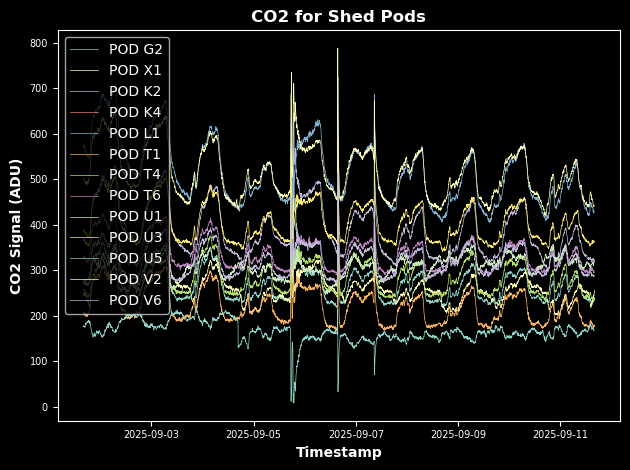

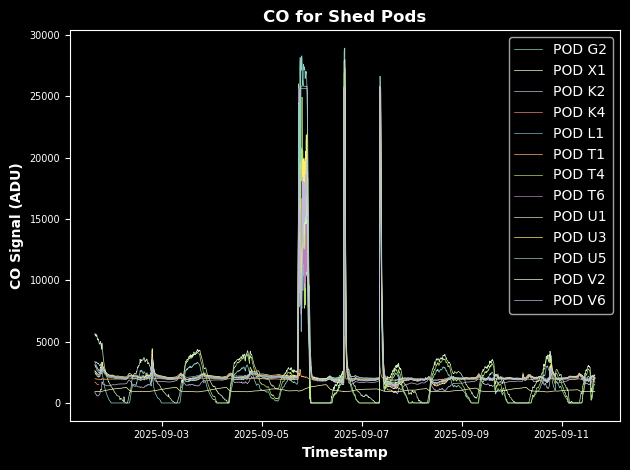

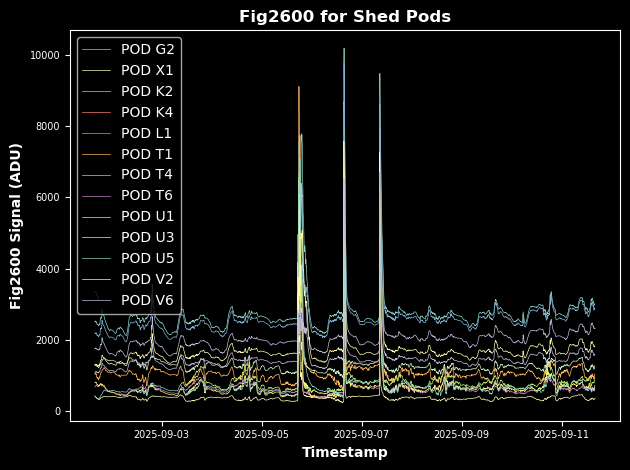

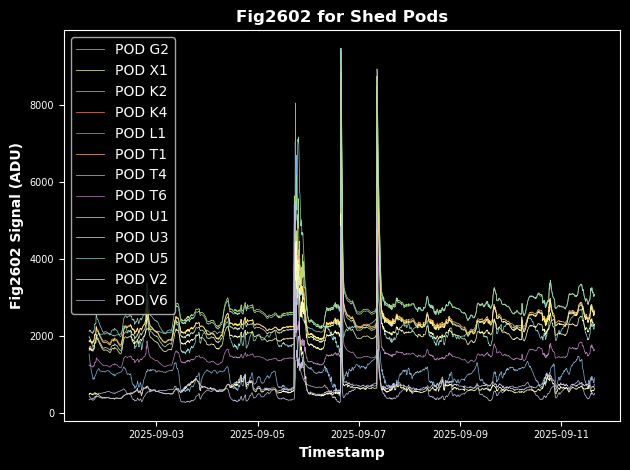

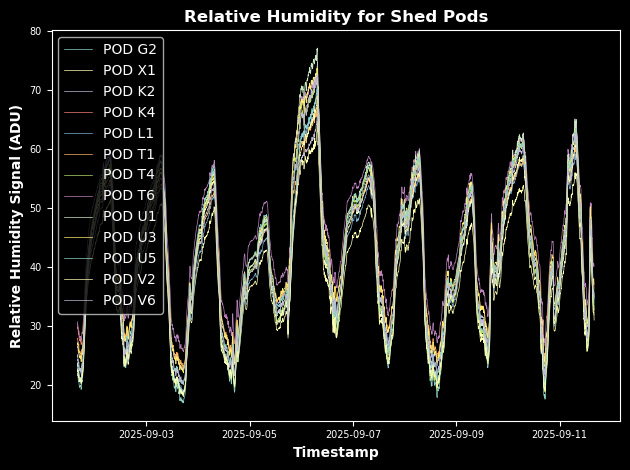

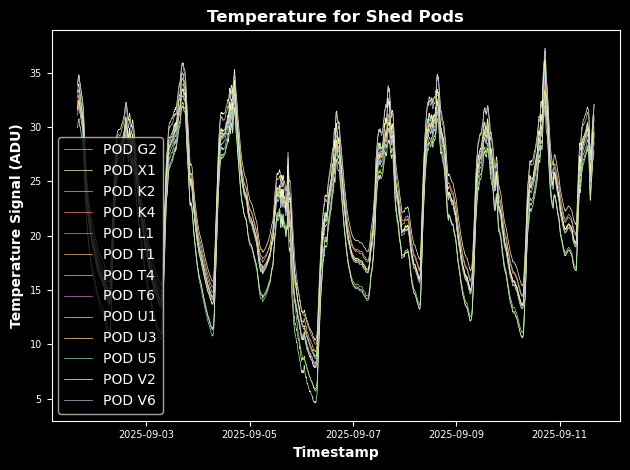

In [17]:
### will store dataframe for each pod
all_pod_data = []

### initializing dicionaries for dynamic plots and axes (saves time when plotting, no hard coded pollutants)
figures = {} # entire figure (top-level container), everything that will share a figure space 
axes = {} # plot where pod data, any axis or format specifications are stored 

if raw_pod_data_plotting == True :  # if statement for plotting toggles  
    ### for loop to create separate figures and axis labels for pollutant plots
    for pollutant in pollutants :
        plt.style.use("dark_background") # dark mode!!
        with plt.style.context("dark_background") :
            fig, ax = plt.subplots() # .subplots creates a new figure space
            figures [pollutant] = fig # updates figure dictionary with pollutant
            axes [pollutant] = ax # updates axis dictionary with pollutant

### for loop to open and format each YPOD data set
for pod in pod_id :
    
    ### reading in files and creating headers
    POD_filename = f"YPOD{pod}_2025_09_01.CSV"
    pod_data = pd.read_csv(POD_filename)
    pod_data.columns = pod_headers
    pod_data.head() # "heads" dataframe
    pod_name = pod_data["PodID"] # stores pod ID for later

    ### formatting timestamps to datetime, cropping dataframe to data window of interest
    pod_data["Timestamp"] = pd.to_datetime(pod_data["Timestamp"], format = "mixed")
    pod_data = pod_data[pod_data["Timestamp"] >= start_cutoff] # deletes all cells before start cutoff
    pod_data = pod_data[pod_data["Timestamp"] <= end_cutoff] # deletes all cells after end cutoff
    pod_data.drop(labels = ["PodID"], axis = 1, inplace = True) # deletes string column

    # bins data to desired resolution
    ### .floor equates all values to the minimum in specified time period
    # data["Timestamp"] = data["Timestamp"].dt.floor("min") # "h" for hourly, "min" for minuetely 

    ### .resample interpolates data with specified bins
    pod_data.set_index("Timestamp", inplace = True) # modifies dataframe directly
    pod_data = pod_data.resample(sample_time).mean().reset_index() # resamples / bins at the appropriate rate

    ### adds back in pod ID to dataframe after resampling for debugging
    pod_data["PodID"] = pod_name
    pod_data.drop(labels = pod_col_drop, axis = 1, inplace = True) # deletes unused columns

    numeric_cols = [col for col in pod_data.columns if col not in ["Timestamp", "PodID"]]
    pod_data[numeric_cols] = pod_data[numeric_cols].apply(pd.to_numeric, errors = "coerce") 
    # print(pod_data[["CO2", "Temperature", "Relative Humidity"]].head(10)) # debugging

    ### saving dataframe in an array for use later
    all_pod_data.append(pod_data)
    
    ### plotting each pollutant
    if raw_pod_data_plotting == True : # if statement for plotting toggles 
        for pollutant in pollutants :
            axes[pollutant].plot(pod_data["Timestamp"], pod_data[pollutant], label = f"POD {pod}", linewidth = 0.5)
            
if raw_pod_data_plotting == True :  # if statement for plotting toggles  
    ### plot formatting, modifies for each pollutant in the pollutants array
    for pollutant in pollutants :
        
        ### plotting specifications
        axes[pollutant].set_xlabel("Timestamp", fontweight = "bold") 
        axes[pollutant].set_ylabel(f"{pollutant} Signal (ADU)", fontweight = "bold")
        axes[pollutant].set_title(f"{pollutant} for Shed Pods", fontweight = "bold")
        axes[pollutant].legend()
        axes[pollutant].tick_params(axis = "x", labelsize = 7) # changes fontsize of x axis
        axes[pollutant].tick_params(axis = "y", labelsize = 7) # changes fontsize of y axis
        figures[pollutant].tight_layout()
        
        ### saving charts to directory for easy access
        if save_plots == True :
            name = f"{pollutant.replace(".", "_")}_shed_pods.png" # renames file to replace . with _ , png type
            path = os.path.join(save_dir, name) # uses path.join for compatibility across os, (good to prevent bugs)
            figures[pollutant].savefig(path, dpi = 300) # saves figure to specified path directory
            print(f"Saved: {path}") # for ui, prints confirmation of saved file

    plt.show()
    # print(pod_data)

### FOLLOWING CODE CELL BLOCK(S): Code for temperature MVLR / calibration fitting

Pod YPODG2 CO model:

Coefficients:
CO: 0.00063
Relative Humidity: -0.01835

Intercept: 0.80675

R-squared: 0.73038
Mean absolute error: 0.5748498674242936
Mean squared error: 2.73168138871964
Root mean squared error: 1.6527798972396899



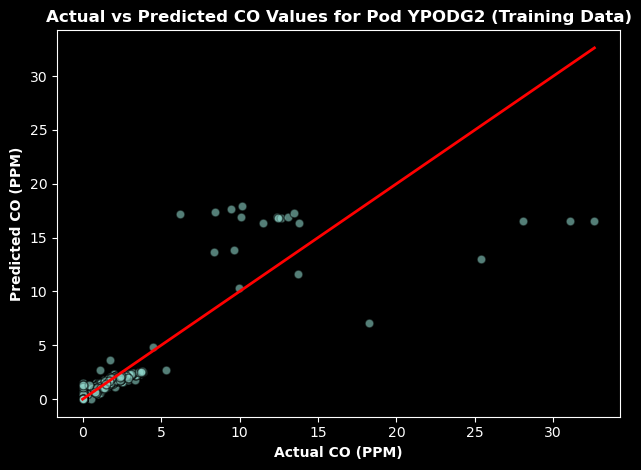

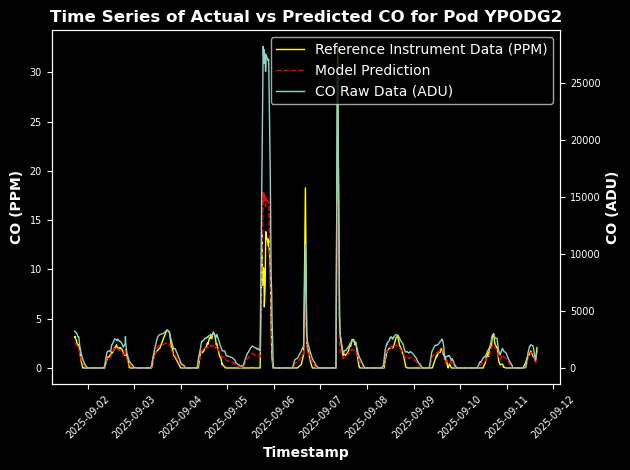

Pod YPODX1 has an incomplete CO data set
Common timestamps: 2880
Reference data size: 2880

Pod YPODX1 CO model:

Coefficients:
CO: 0.00112
Relative Humidity: -0.07804

Intercept: 1.25783

R-squared: 0.91407
Mean absolute error: 0.535533095665846
Mean squared error: 0.8706132792412123
Root mean squared error: 0.9330665995743349



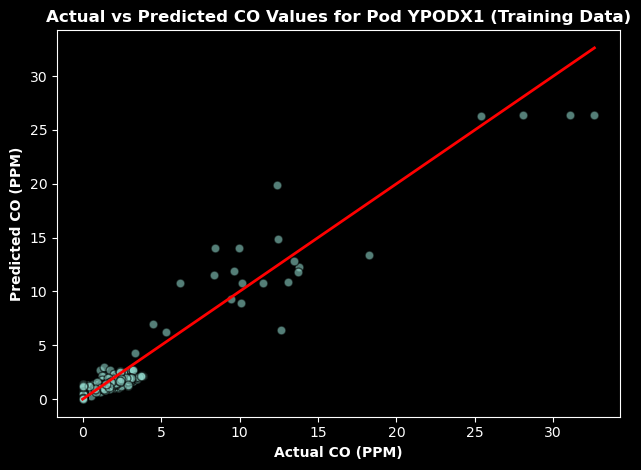

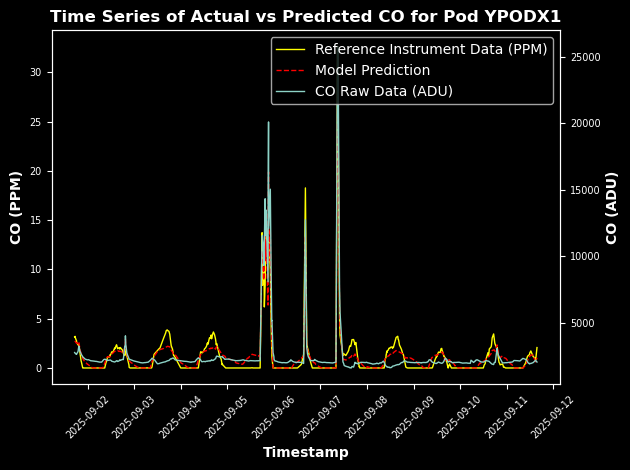

Pod YPODK2 has an incomplete CO data set
Common timestamps: 2880
Reference data size: 2880

Pod YPODK2 CO model:

Coefficients:
CO: 0.00064
Relative Humidity: -0.09269

Intercept: 3.50931

R-squared: 0.71800
Mean absolute error: 0.6804809144760419
Mean squared error: 2.8571200586428276
Root mean squared error: 1.6903017655563244



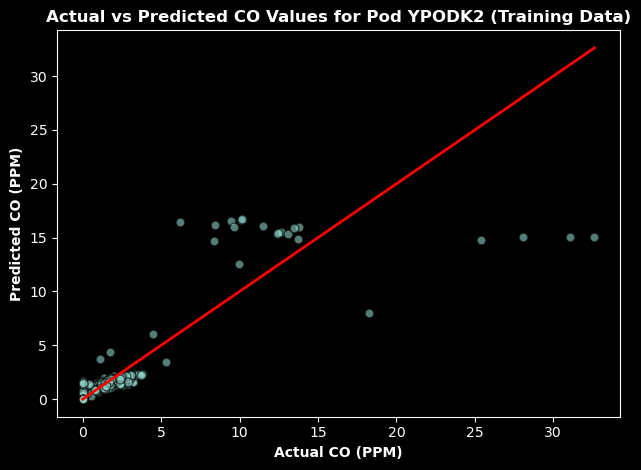

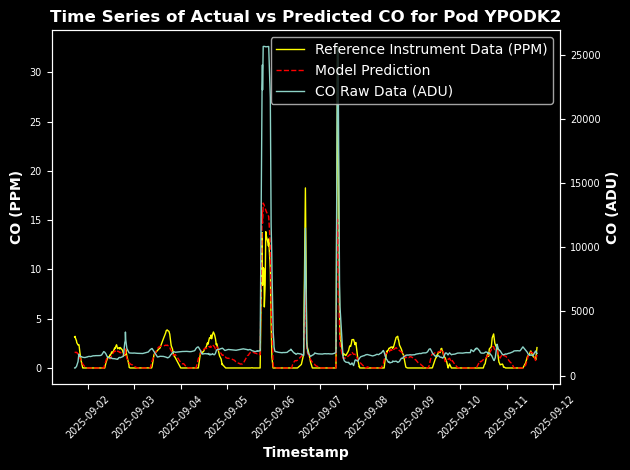

Pod YPODK4 has an incomplete CO data set
Common timestamps: 24
Reference data size: 2880

Pod YPODK4 CO model:

Coefficients:
CO: 0.00104
Relative Humidity: -0.03188

Intercept: 2.48679

R-squared: -0.53402
Mean absolute error: 0.15939911623791464
Mean squared error: 0.03370869037944037
Root mean squared error: 0.18359926573774843



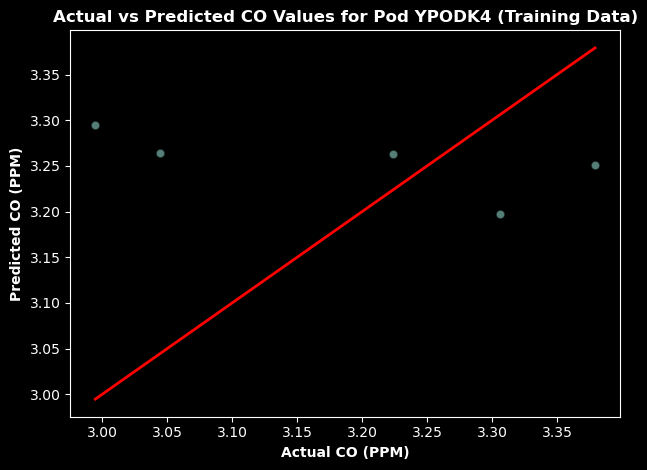

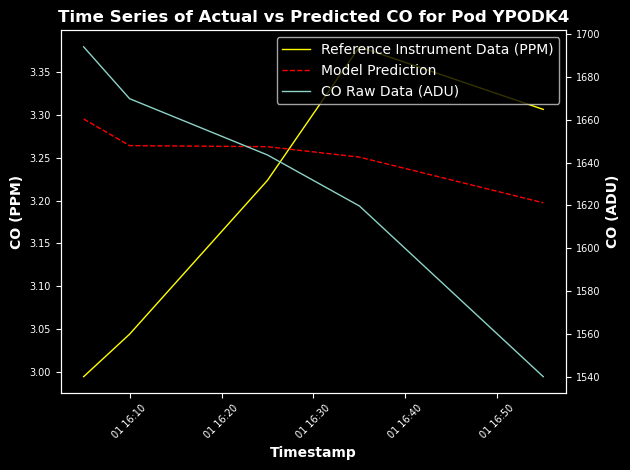

Pod YPODL1 CO model:

Coefficients:
CO: 0.00141
Relative Humidity: -0.06593

Intercept: 0.28656

R-squared: 0.94495
Mean absolute error: 0.4900552658748748
Mean squared error: 0.5577171621748922
Root mean squared error: 0.7468046345429923



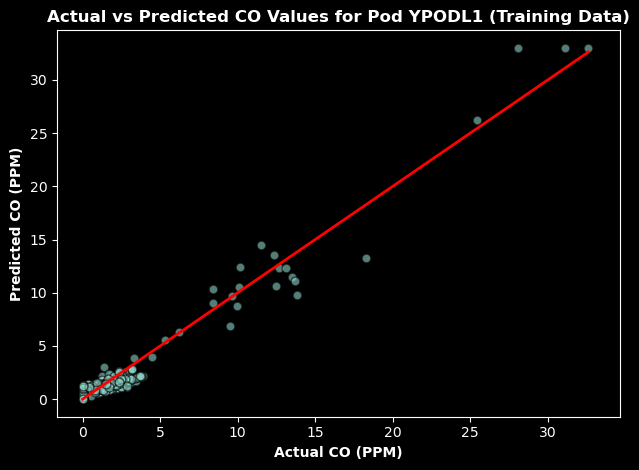

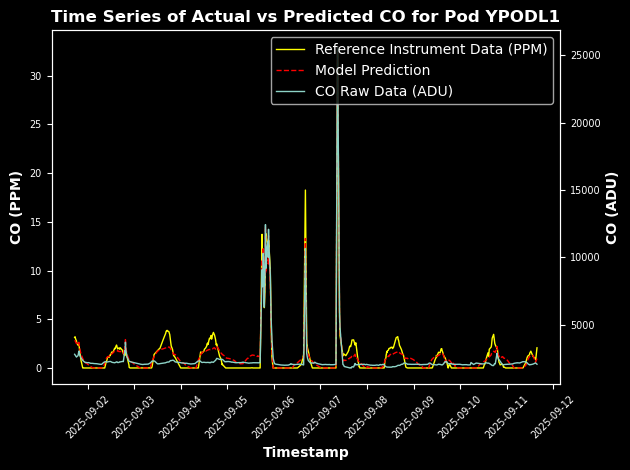

Pod YPODT1 CO model:

Coefficients:
CO: 0.01298
Relative Humidity: -0.07268

Intercept: -21.18629

R-squared: 0.50384
Mean absolute error: 0.9904714122390117
Mean squared error: 5.026919457142139
Root mean squared error: 2.242079270931815



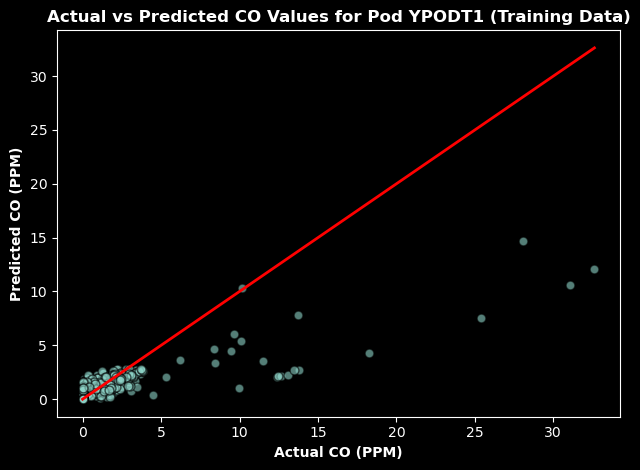

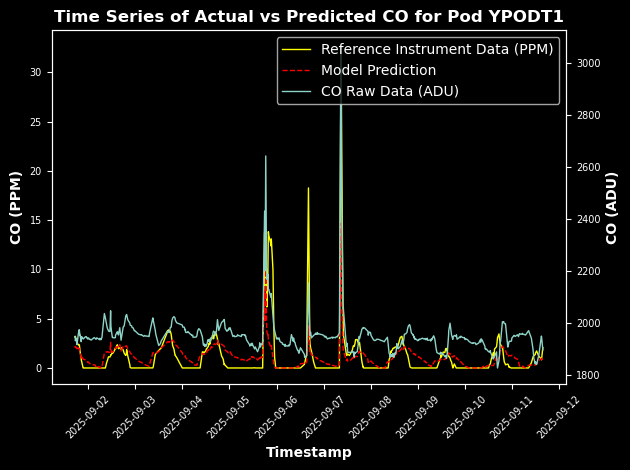

Pod YPODT4 has an incomplete CO data set
Common timestamps: 2383
Reference data size: 2880

Pod YPODT4 CO model:

Coefficients:
CO: 0.00090
Relative Humidity: 0.02147

Intercept: -1.46019

R-squared: 0.78633
Mean absolute error: 0.6062238681891514
Mean squared error: 2.9093549847384956
Root mean squared error: 1.7056831431243307



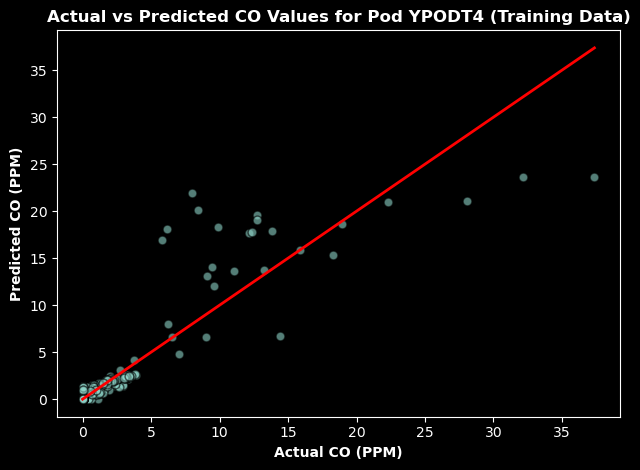

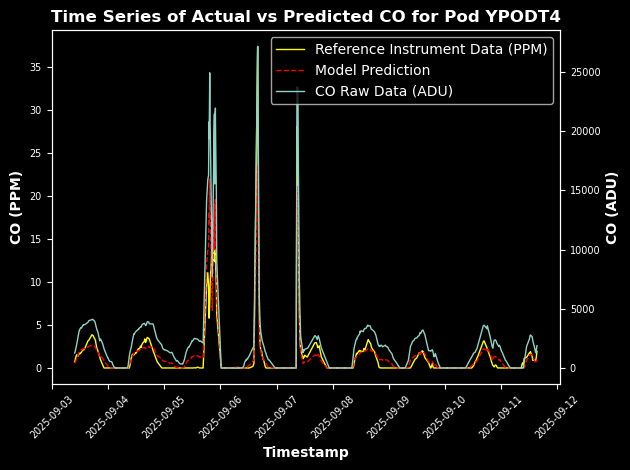

Pod YPODT6 CO model:

Coefficients:
CO: 0.00112
Relative Humidity: -0.07675

Intercept: 1.95190

R-squared: 0.92439
Mean absolute error: 0.561341038656478
Mean squared error: 0.7660517103028291
Root mean squared error: 0.875243800493799



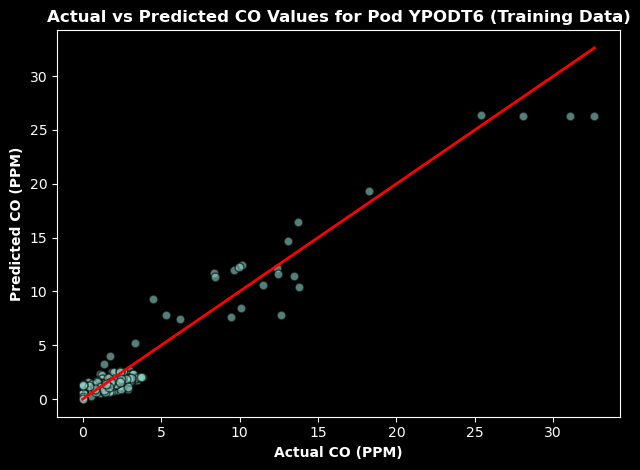

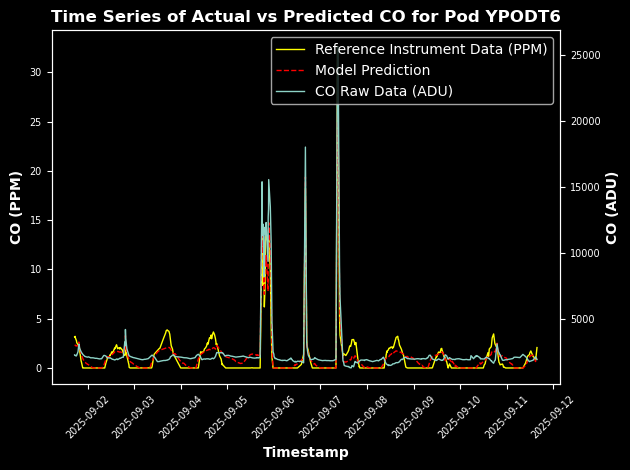

Pod YPODU1 CO model:

Coefficients:
CO: 0.00096
Relative Humidity: 0.02904

Intercept: -2.28105

R-squared: 0.92373
Mean absolute error: 0.4816260615711212
Mean squared error: 0.7727813639365019
Root mean squared error: 0.8790798393414001



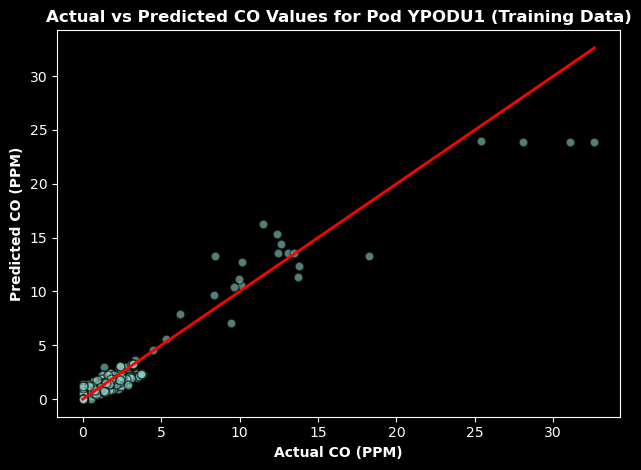

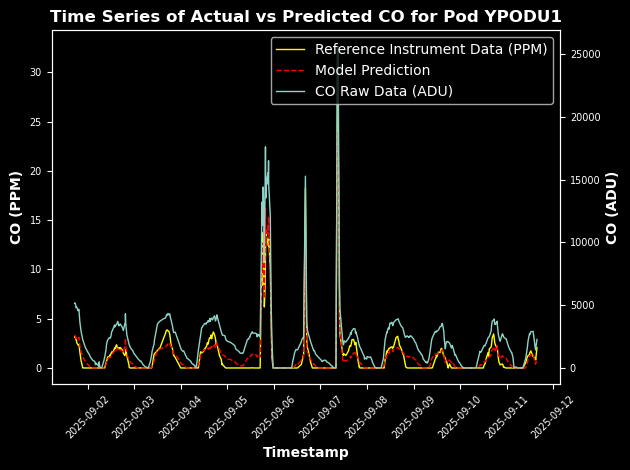

Pod YPODU3 CO model:

Coefficients:
CO: 0.00093
Relative Humidity: -0.07671

Intercept: 2.07106

R-squared: 0.89587
Mean absolute error: 0.5612483746090494
Mean squared error: 1.0549865368136517
Root mean squared error: 1.027125375411226



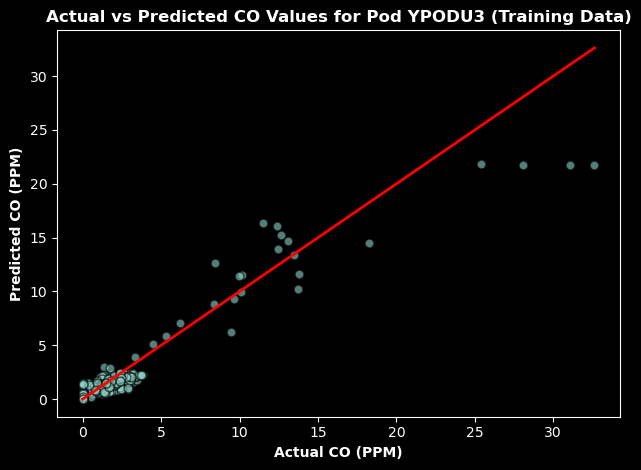

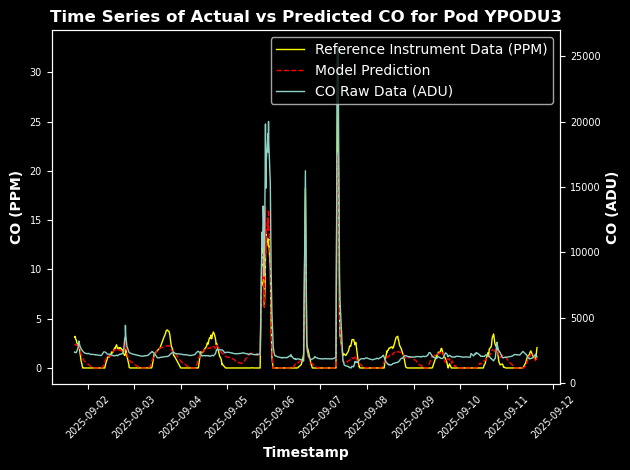

Pod YPODU5 CO model:

Coefficients:
CO: 0.00068
Relative Humidity: -0.07564

Intercept: 2.55893

R-squared: 0.72956
Mean absolute error: 0.6488228724824973
Mean squared error: 2.740060237020308
Root mean squared error: 1.6553127308820856



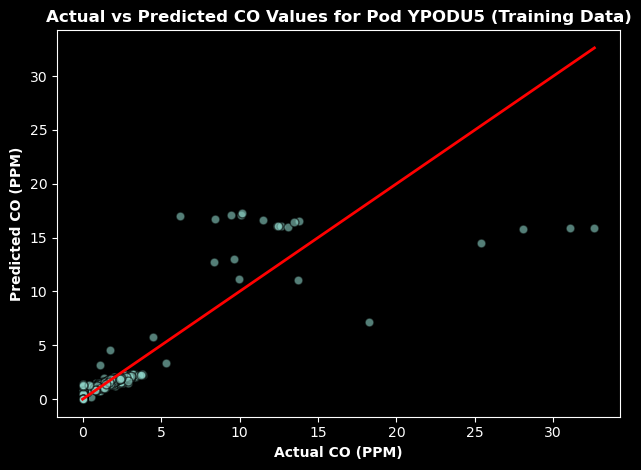

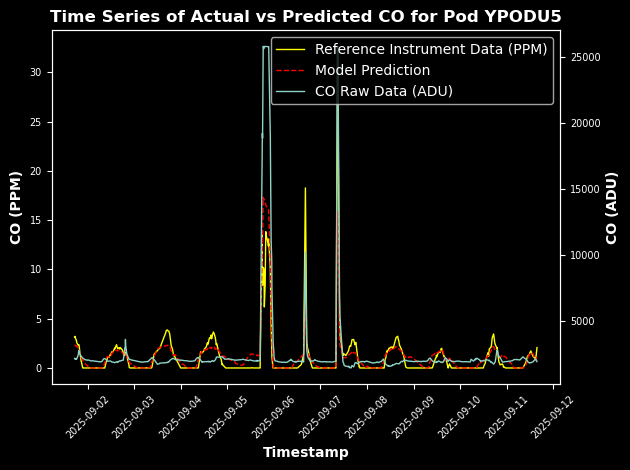

Pod YPODV2 CO model:

Coefficients:
CO: 0.00140
Relative Humidity: -0.07885

Intercept: 2.79850

R-squared: 0.02022
Mean absolute error: 1.0848320556515996
Mean squared error: 9.926861460076728
Root mean squared error: 3.150692219191955



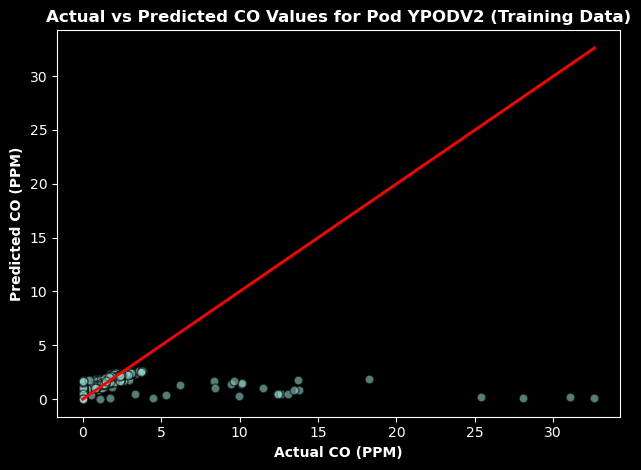

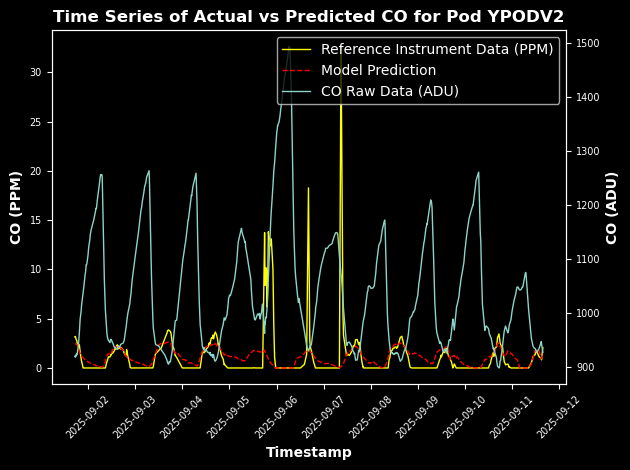

Pod YPODV6 CO model:

Coefficients:
CO: 0.00109
Relative Humidity: -0.07102

Intercept: 1.42407

R-squared: 0.91083
Mean absolute error: 0.5460514123788505
Mean squared error: 0.9034905547160074
Root mean squared error: 0.9505212016130978



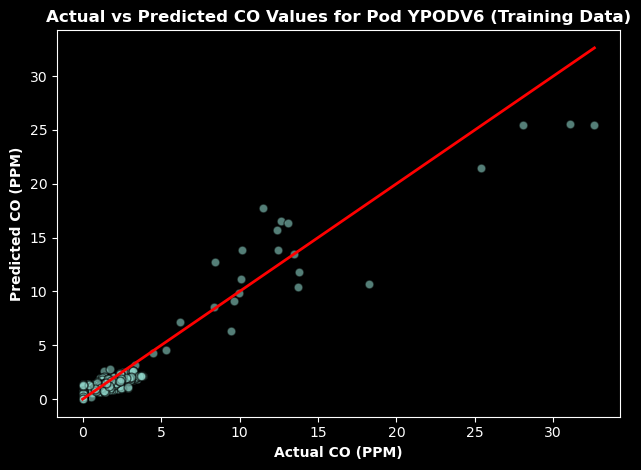

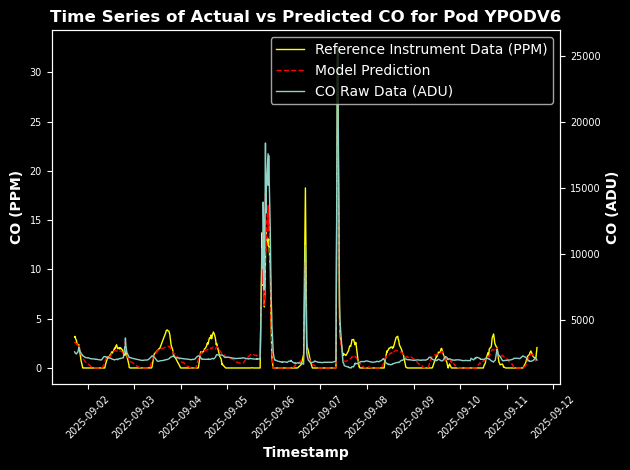

Pod YPODG2 CO2 model:

Coefficients:
CO2: 0.55602
Temperature: 0.19516
Relative Humidity: 0.54968

Intercept: 95.73991

R-squared: 0.71958
Mean absolute error: 9.713496680239713
Mean squared error: 221.89972794415942
Root mean squared error: 14.896299135831



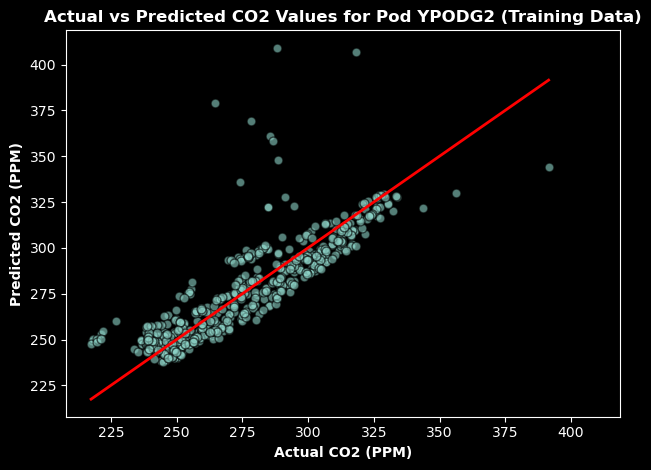

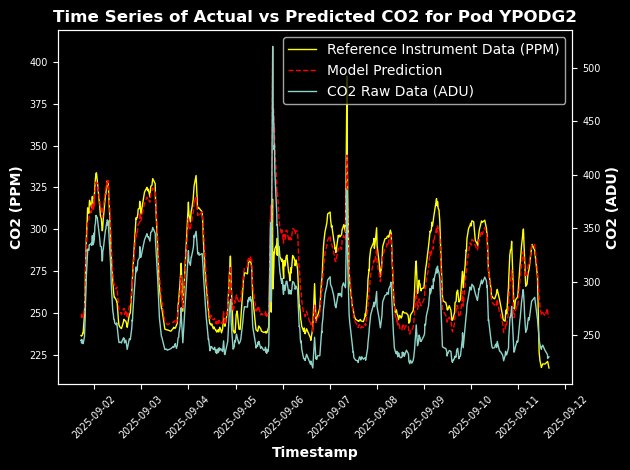

Pod YPODX1 has an incomplete CO2 data set
Common timestamps: 2880
Reference data size: 2880

Pod YPODX1 CO2 model:

Coefficients:
CO2: 0.37740
Temperature: -2.27307
Relative Humidity: 0.10422

Intercept: 224.94861

R-squared: 0.58568
Mean absolute error: 14.137029944188306
Mean squared error: 327.85829063672827
Root mean squared error: 18.106857558304487



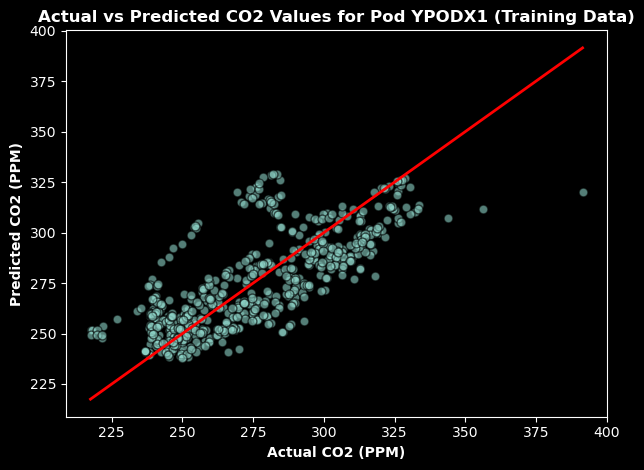

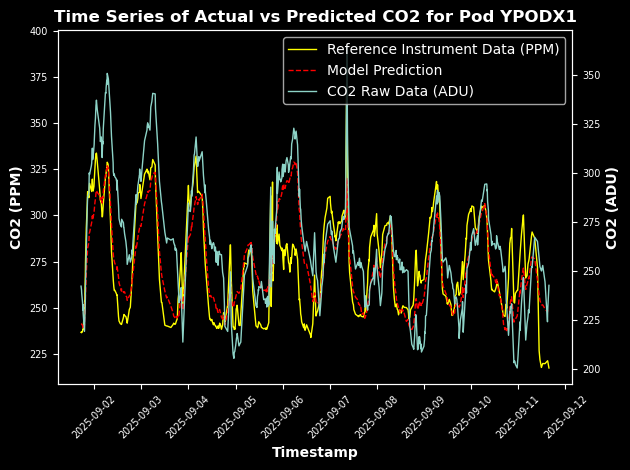

Pod YPODK2 has an incomplete CO2 data set
Common timestamps: 2880
Reference data size: 2880

Pod YPODK2 CO2 model:

Coefficients:
CO2: 0.35536
Temperature: 0.53309
Relative Humidity: 0.79715

Intercept: 87.70961

R-squared: 0.63758
Mean absolute error: 13.450347029984275
Mean squared error: 286.7939266551359
Root mean squared error: 16.9349911914691



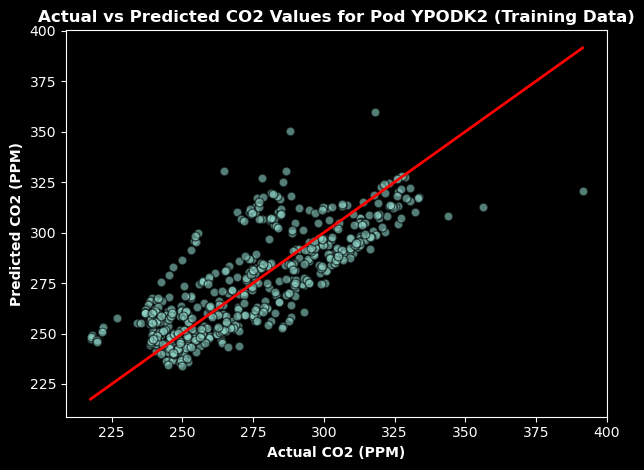

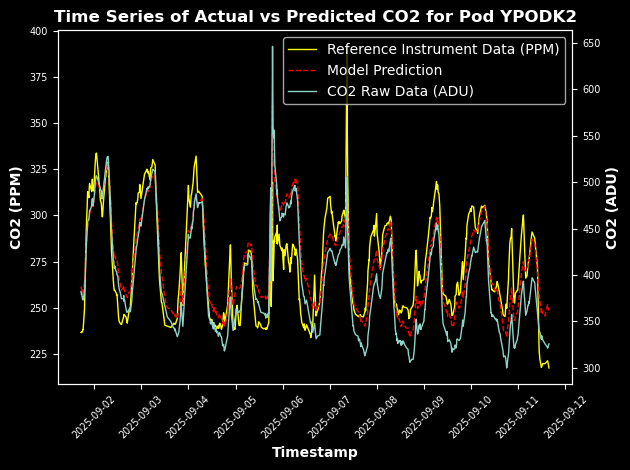

Pod YPODK4 has an incomplete CO2 data set
Common timestamps: 24
Reference data size: 2880

Pod YPODK4 CO2 model:

Coefficients:
CO2: 0.12600
Temperature: 0.24465
Relative Humidity: 0.10824

Intercept: 194.66031

R-squared: -2.83803
Mean absolute error: 0.4777599075216642
Mean squared error: 0.31560644278519406
Root mean squared error: 0.5617886104089278



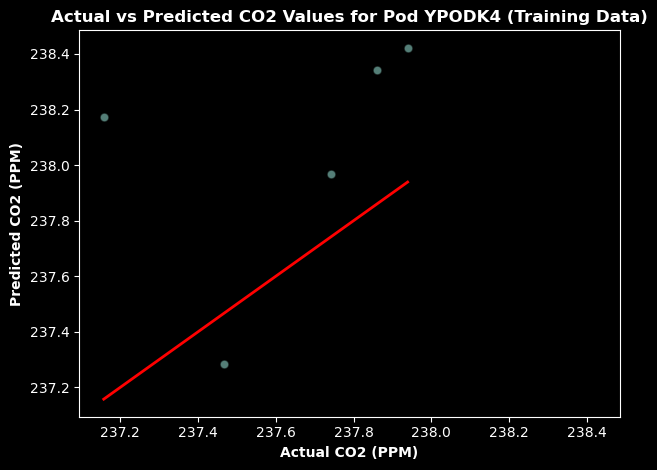

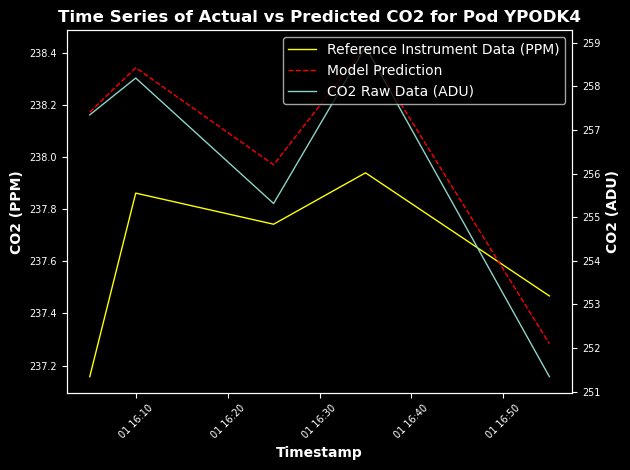

Pod YPODL1 CO2 model:

Coefficients:
CO2: 0.26675
Temperature: -0.44070
Relative Humidity: 0.40967

Intercept: 128.64243

R-squared: 0.65543
Mean absolute error: 13.061539601389514
Mean squared error: 272.66397214768057
Root mean squared error: 16.51253984545323



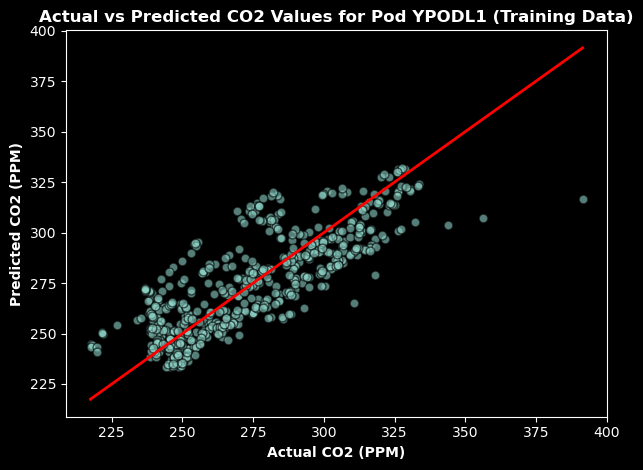

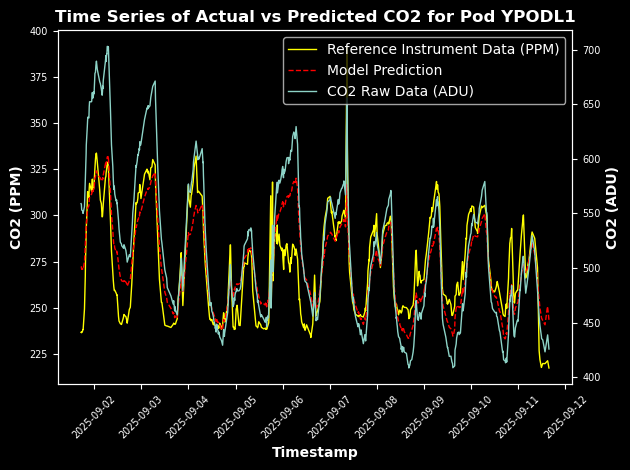

Pod YPODT1 CO2 model:

Coefficients:
CO2: 0.71347
Temperature: 1.59258
Relative Humidity: 0.95026

Intercept: 37.41322

R-squared: 0.82311
Mean absolute error: 9.81239526210104
Mean squared error: 139.9756496212963
Root mean squared error: 11.831130530143614



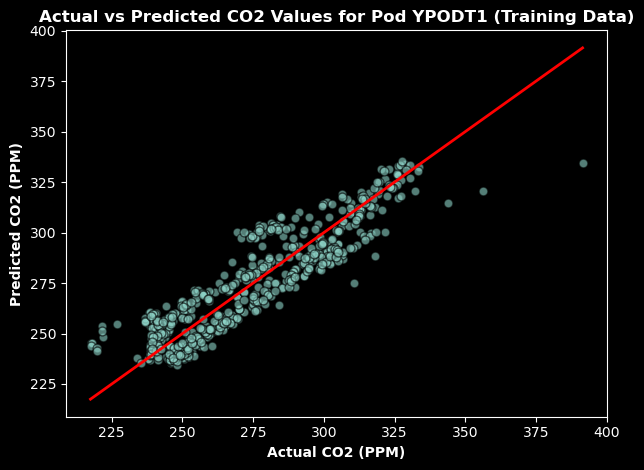

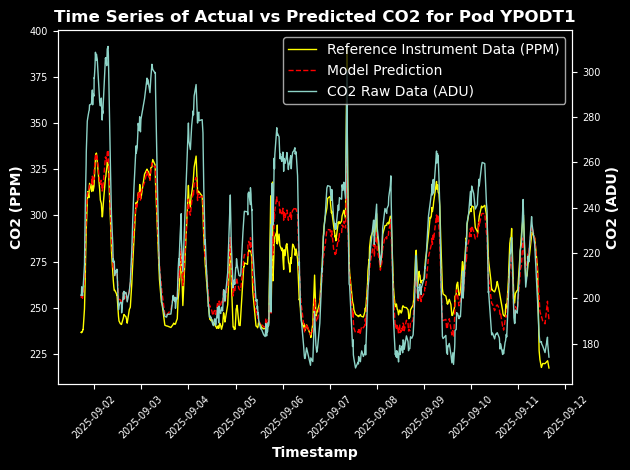

Pod YPODT4 has an incomplete CO2 data set
Common timestamps: 2383
Reference data size: 2880

Pod YPODT4 CO2 model:

Coefficients:
CO2: 0.84209
Temperature: 2.49295
Relative Humidity: 0.77502

Intercept: -52.25511

R-squared: 0.88216
Mean absolute error: 6.796470577721859
Mean squared error: 79.09824660788773
Root mean squared error: 8.89371950355349



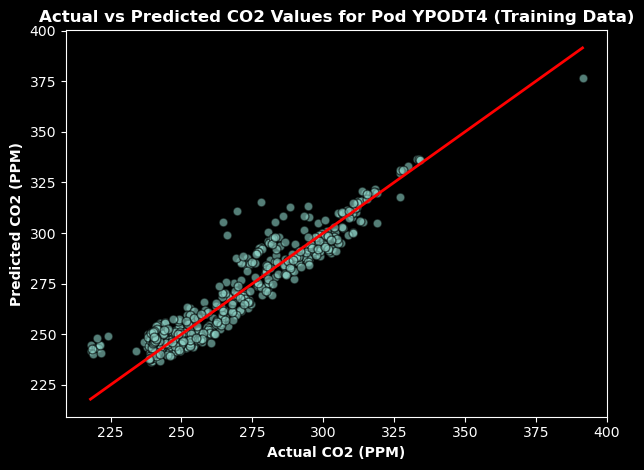

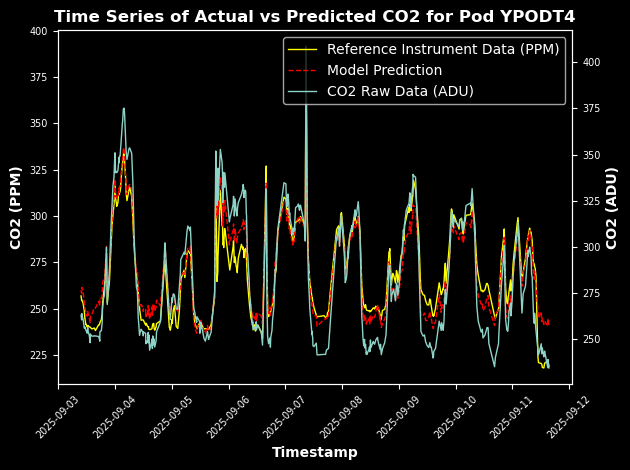

Pod YPODT6 CO2 model:

Coefficients:
CO2: 0.77203
Temperature: 0.98741
Relative Humidity: 0.68218

Intercept: -41.27804

R-squared: 0.87736
Mean absolute error: 8.334961027043366
Mean squared error: 97.05171673389063
Root mean squared error: 9.851482971303895



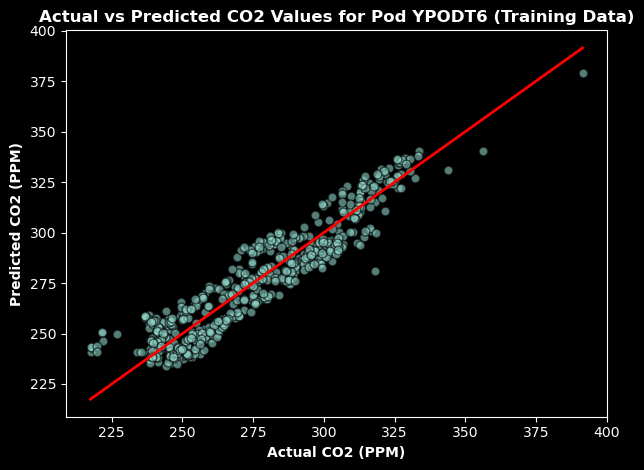

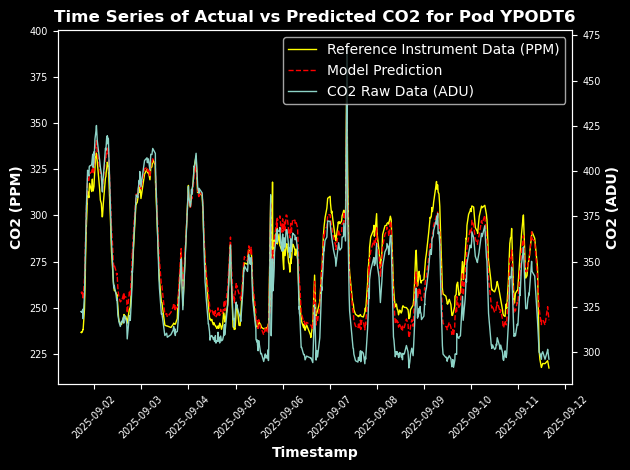

Pod YPODU1 CO2 model:

Coefficients:
CO2: 0.58073
Temperature: -2.26283
Relative Humidity: 0.19558

Intercept: 131.85519

R-squared: 0.66362
Mean absolute error: 12.755067009119083
Mean squared error: 266.1854419931551
Root mean squared error: 16.31519052886466



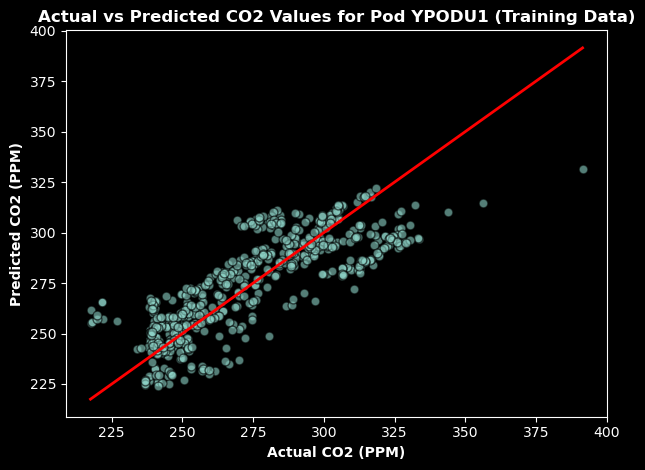

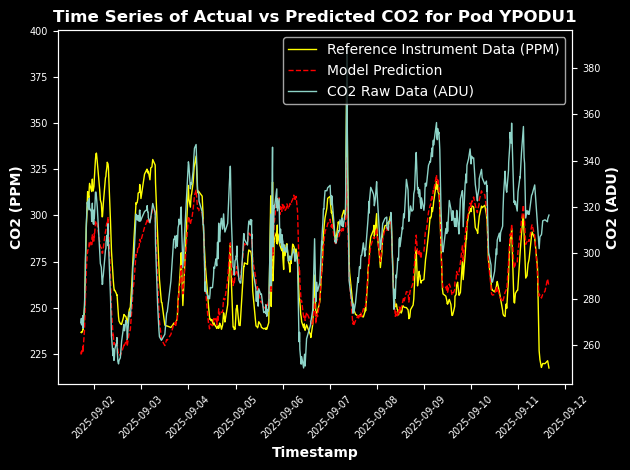

Pod YPODU3 CO2 model:

Coefficients:
CO2: 0.78940
Temperature: 1.48442
Relative Humidity: 0.02548

Intercept: -81.97484

R-squared: 0.86264
Mean absolute error: 8.458598078716363
Mean squared error: 108.69309663150955
Root mean squared error: 10.425598142625176



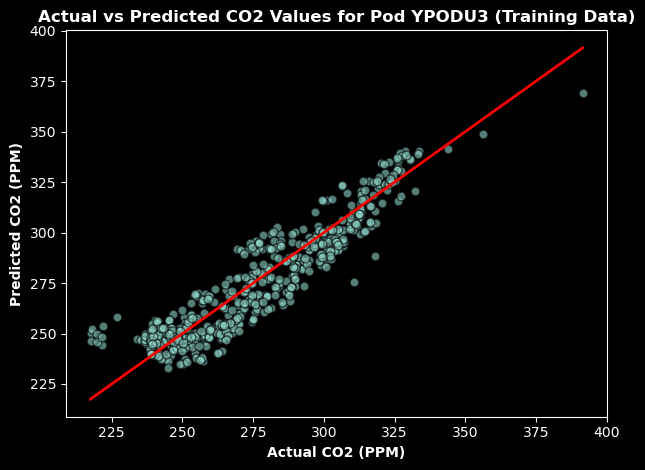

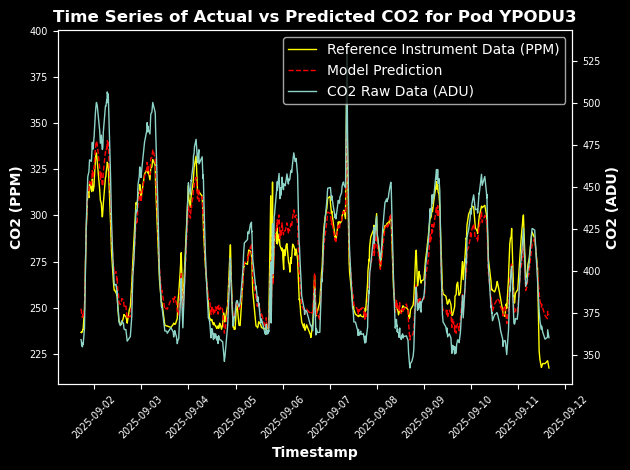

Pod YPODU5 CO2 model:

Coefficients:
CO2: -0.23080
Temperature: -2.26921
Relative Humidity: 0.52369

Intercept: 340.17171

R-squared: 0.52613
Mean absolute error: 14.19017963404121
Mean squared error: 374.98836340276034
Root mean squared error: 19.364616273057422



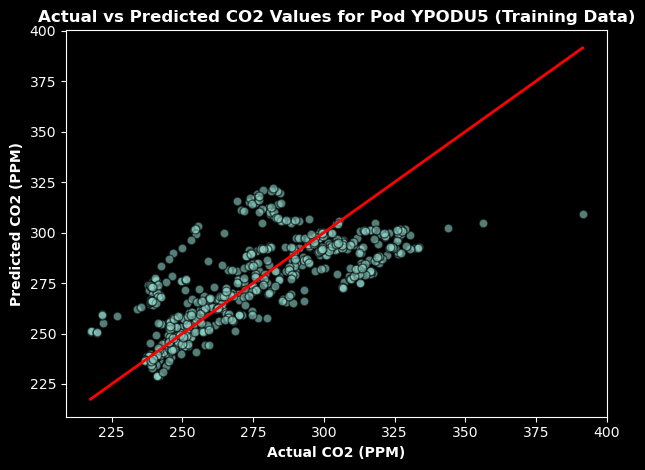

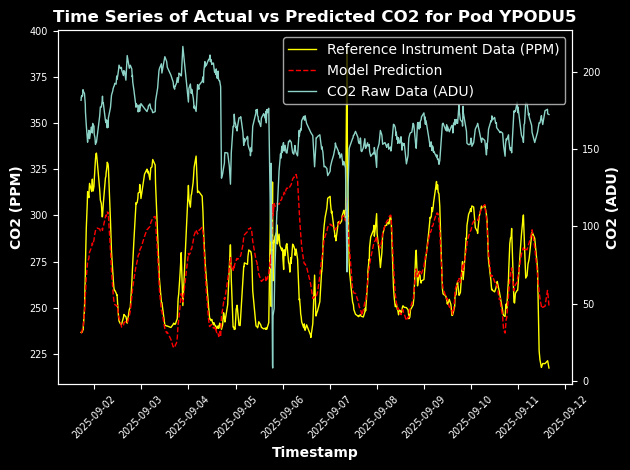

Pod YPODV2 CO2 model:

Coefficients:
CO2: 0.50596
Temperature: 1.00766
Relative Humidity: 0.35266

Intercept: -25.15380

R-squared: 0.75131
Mean absolute error: 10.419873153672128
Mean squared error: 196.79178718653054
Root mean squared error: 14.028249612354728



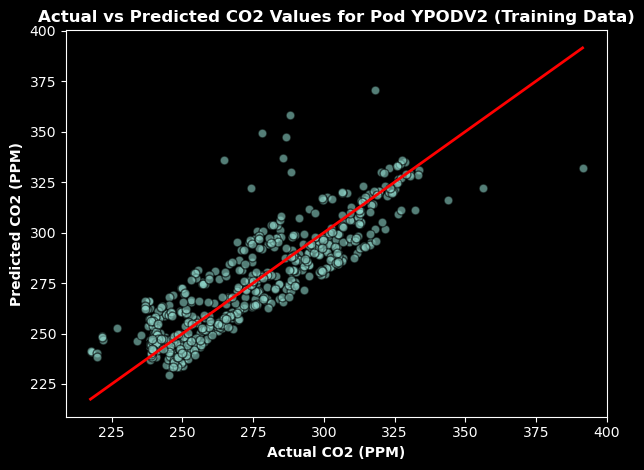

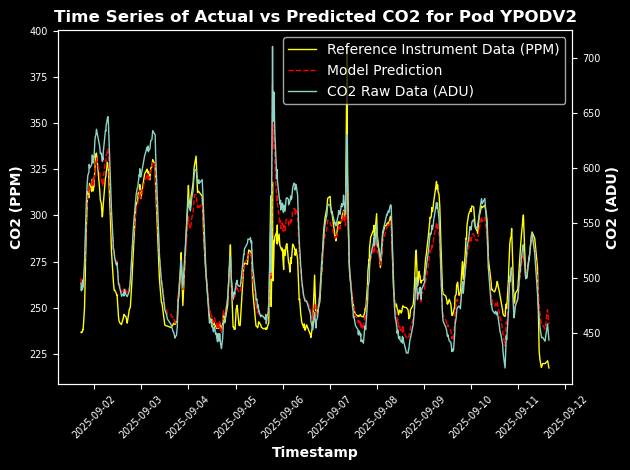

Pod YPODV6 CO2 model:

Coefficients:
CO2: 0.94356
Temperature: 1.72155
Relative Humidity: 0.53461

Intercept: -90.12135

R-squared: 0.89154
Mean absolute error: 6.654460444189021
Mean squared error: 85.82494971789849
Root mean squared error: 9.26417560918933



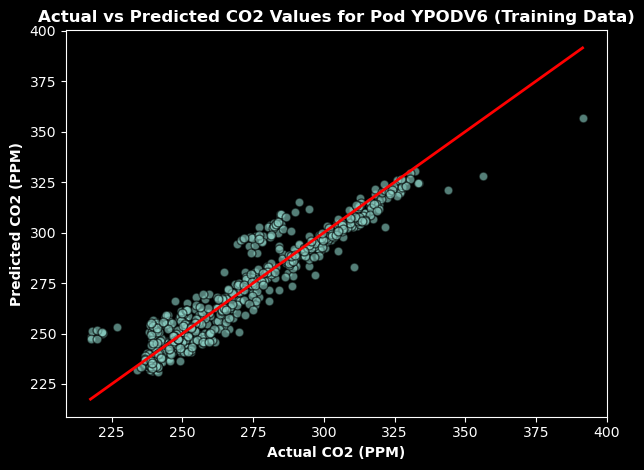

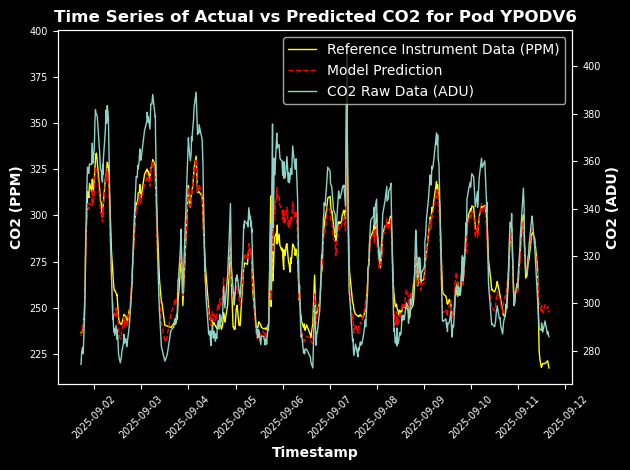

Pod YPODG2 Temperature model:

Coefficients:
Temperature: 0.84724

Intercept: 6.61165

R-squared: 0.99025
Mean absolute error: 0.37636975867726413
Mean squared error: 0.3153659587471124
Root mean squared error: 0.5615745353442518



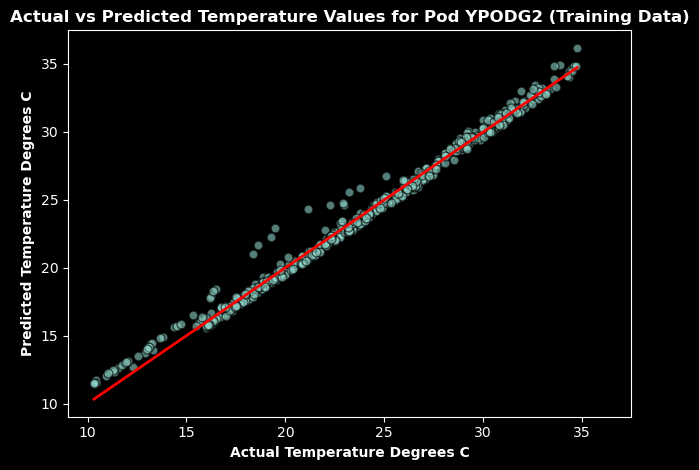

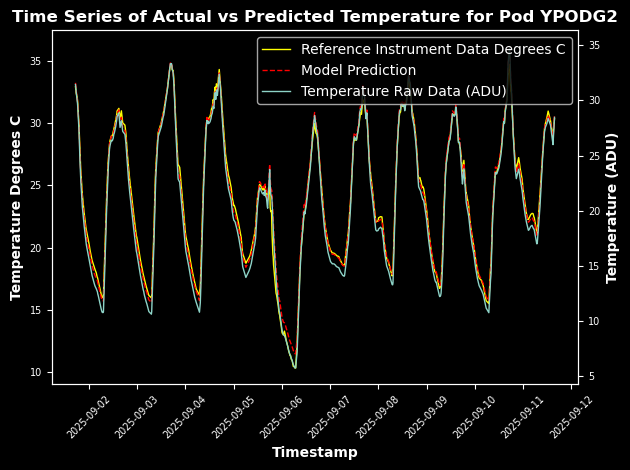

Pod YPODX1 has an incomplete Temperature data set
Common timestamps: 2880
Reference data size: 2880

Pod YPODX1 Temperature model:

Coefficients:
Temperature: 0.93920

Intercept: 1.15479

R-squared: 0.99686
Mean absolute error: 0.23542096192462114
Mean squared error: 0.10159880633281818
Root mean squared error: 0.31874567657117825



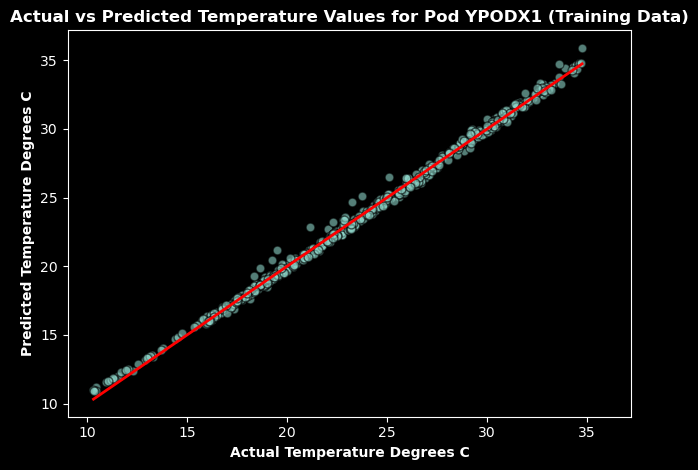

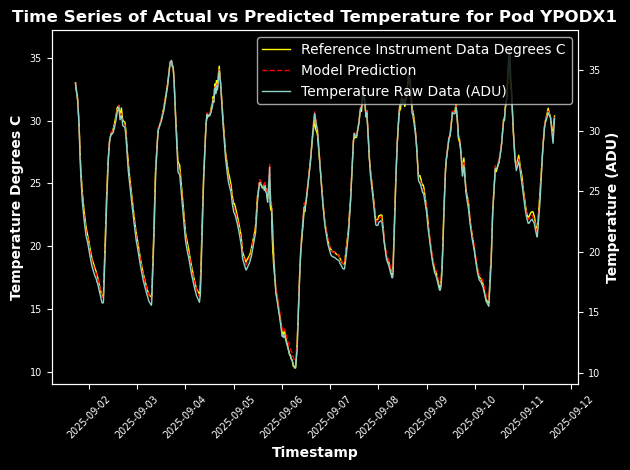

Pod YPODK2 has an incomplete Temperature data set
Common timestamps: 2880
Reference data size: 2880

Pod YPODK2 Temperature model:

Coefficients:
Temperature: 0.91166

Intercept: 2.37415

R-squared: 0.98747
Mean absolute error: 0.42511899390087104
Mean squared error: 0.4051234355417608
Root mean squared error: 0.636493075800327



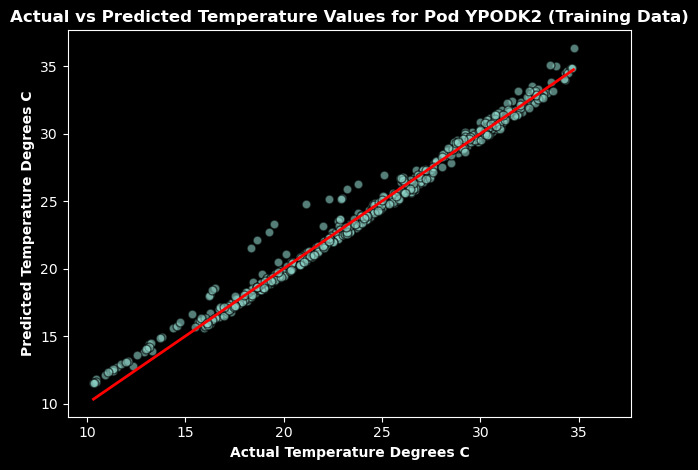

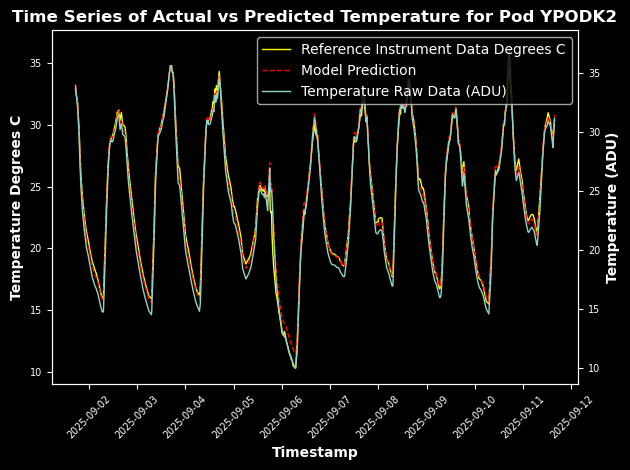

Pod YPODK4 has an incomplete Temperature data set
Common timestamps: 24
Reference data size: 2880

Pod YPODK4 Temperature model:

Coefficients:
Temperature: 0.74876

Intercept: 8.74466

R-squared: 0.83574
Mean absolute error: 0.07225626917191334
Mean squared error: 0.008090268243340306
Root mean squared error: 0.0899459184362487



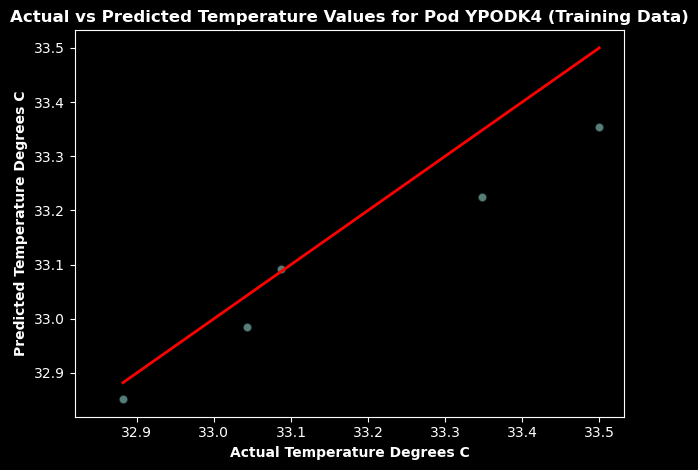

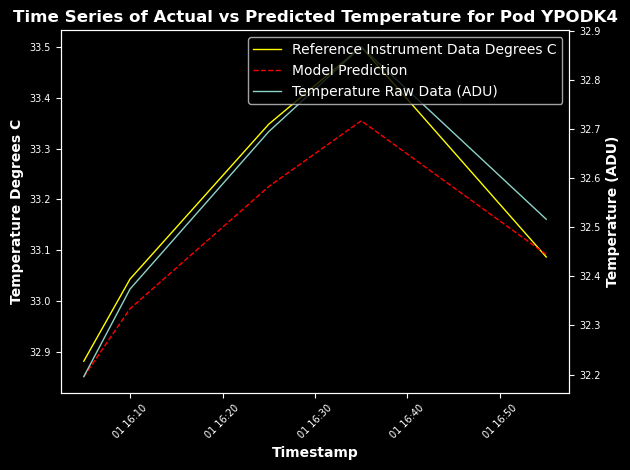

Pod YPODL1 Temperature model:

Coefficients:
Temperature: 0.97813

Intercept: 2.11855

R-squared: 0.99907
Mean absolute error: 0.125742574989828
Mean squared error: 0.02994581527126004
Root mean squared error: 0.17304859222559438



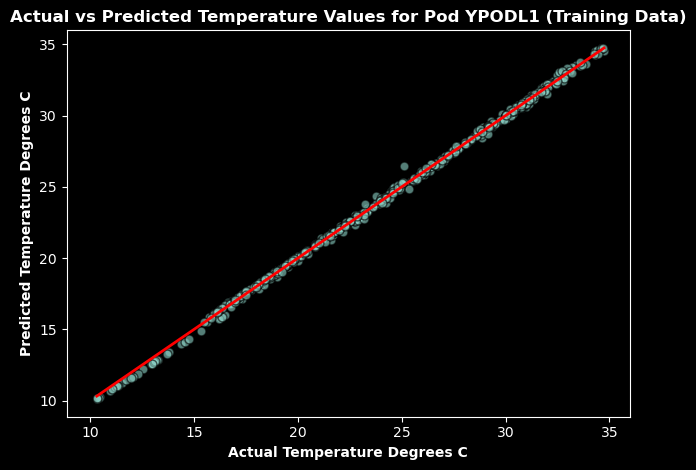

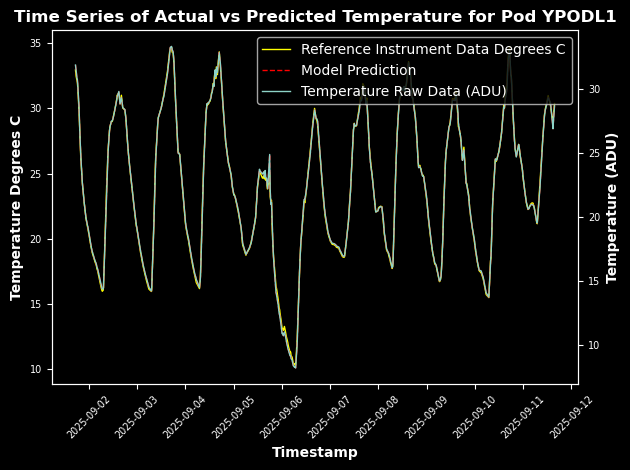

Pod YPODT1 Temperature model:

Coefficients:
Temperature: 1.01573

Intercept: 0.67322

R-squared: 0.99970
Mean absolute error: 0.0769122383837641
Mean squared error: 0.009700171736647214
Root mean squared error: 0.09848944987483285



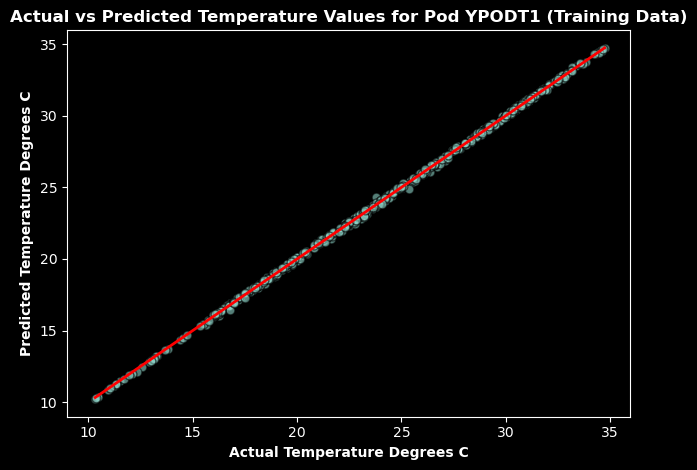

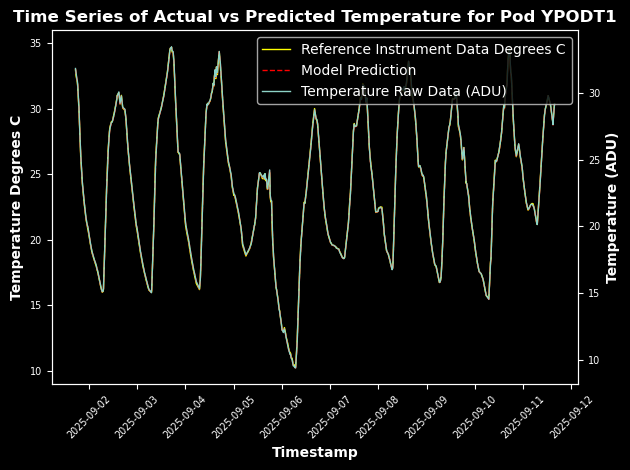

Pod YPODT4 has an incomplete Temperature data set
Common timestamps: 2383
Reference data size: 2880

Pod YPODT4 Temperature model:

Coefficients:
Temperature: 0.90596

Intercept: 5.46401

R-squared: 0.99787
Mean absolute error: 0.1879612675456622
Mean squared error: 0.07057972563313353
Root mean squared error: 0.26566845057916366



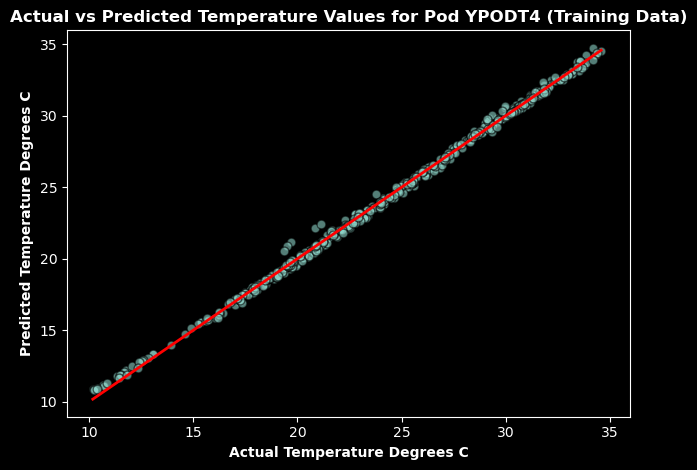

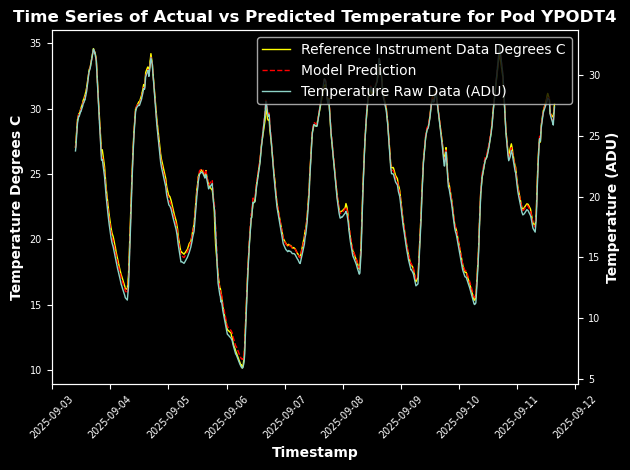

Pod YPODT6 Temperature model:

Coefficients:
Temperature: 0.95264

Intercept: 2.58850

R-squared: 0.99843
Mean absolute error: 0.16264287077238504
Mean squared error: 0.05076858367320928
Root mean squared error: 0.2253188489079626



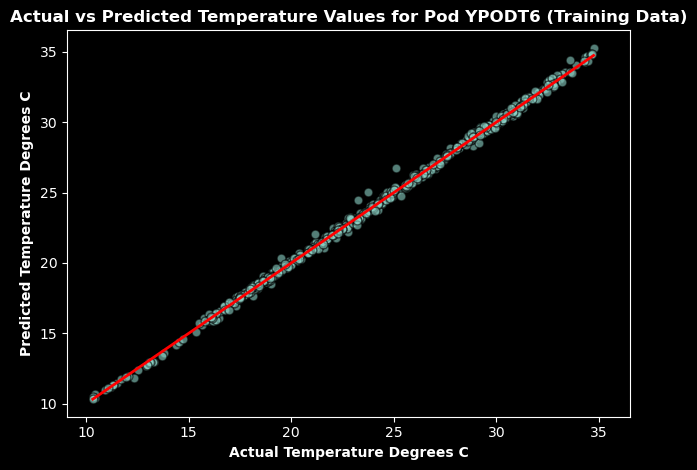

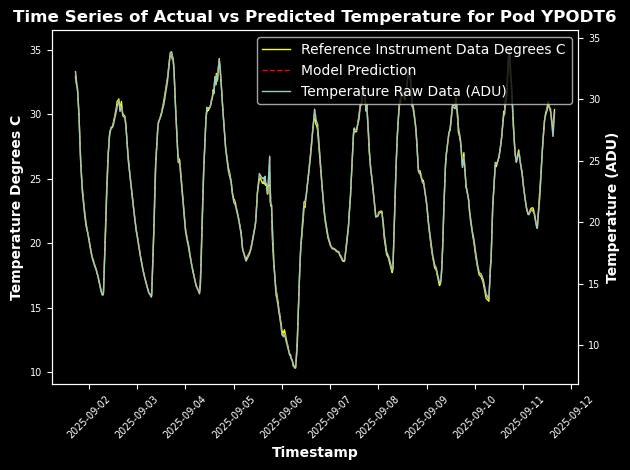

Pod YPODU1 Temperature model:

Coefficients:
Temperature: 0.90005

Intercept: 5.92651

R-squared: 0.99937
Mean absolute error: 0.10288148300997631
Mean squared error: 0.020456280733170504
Root mean squared error: 0.14302545484343165



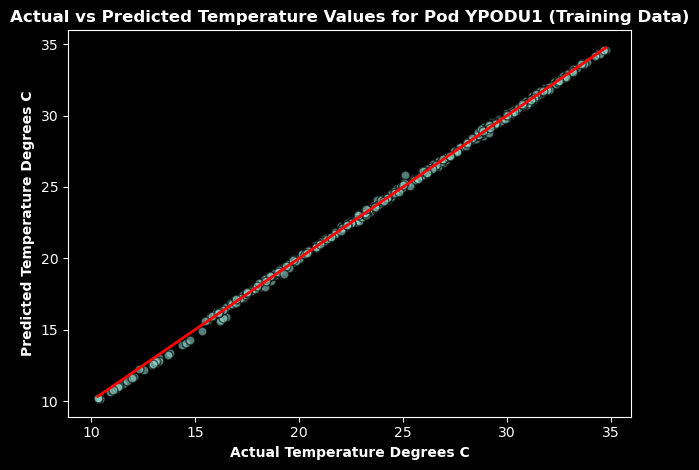

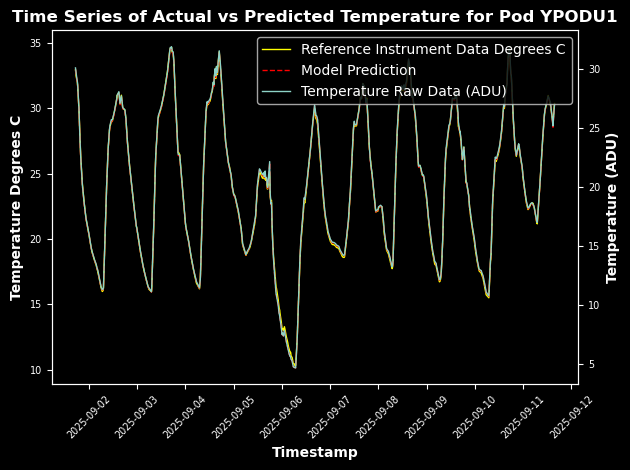

Pod YPODU3 Temperature model:

Coefficients:
Temperature: 0.96286

Intercept: 2.42155

R-squared: 0.99916
Mean absolute error: 0.1128456248369815
Mean squared error: 0.027068292776379566
Root mean squared error: 0.1645244443126296



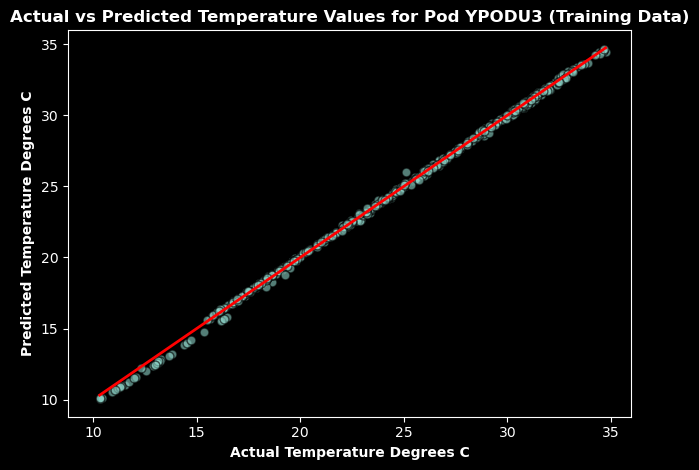

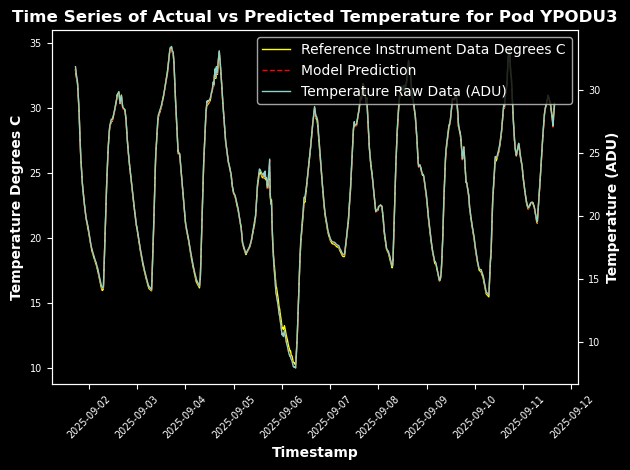

Pod YPODU5 Temperature model:

Coefficients:
Temperature: 0.92305

Intercept: 3.22576

R-squared: 0.99117
Mean absolute error: 0.37650364397733915
Mean squared error: 0.28534131146660147
Root mean squared error: 0.5341734844286091



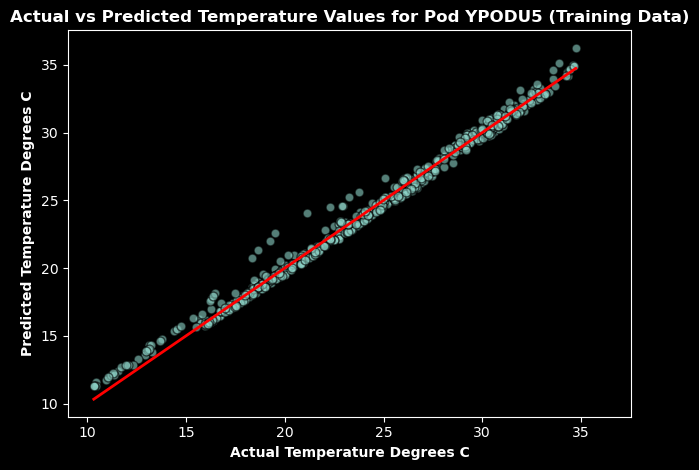

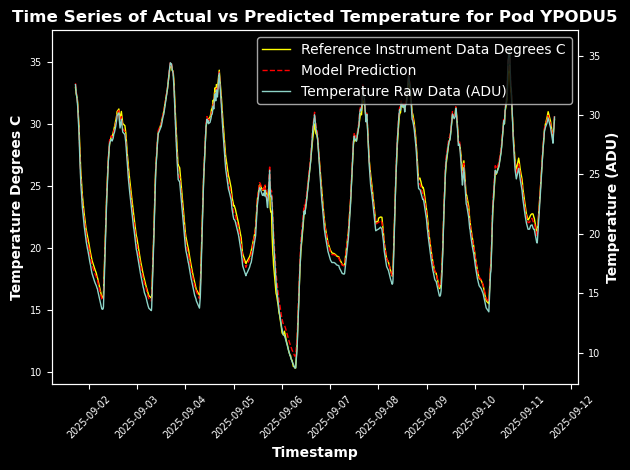

Pod YPODV2 Temperature model:

Coefficients:
Temperature: 0.91601

Intercept: 3.16763

R-squared: 0.99103
Mean absolute error: 0.38079462380450635
Mean squared error: 0.2899808758854964
Root mean squared error: 0.5384987241261546



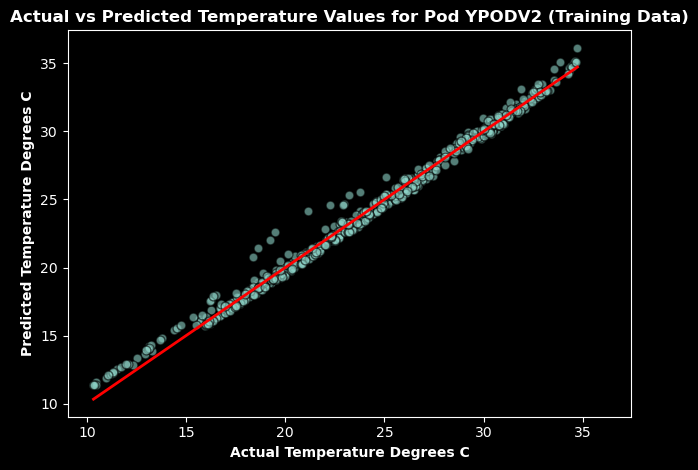

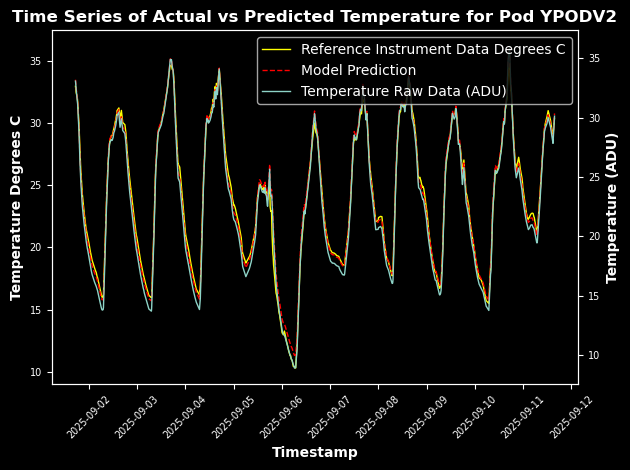

Pod YPODV6 Temperature model:

Coefficients:
Temperature: 0.98436

Intercept: 2.31866

R-squared: 0.99964
Mean absolute error: 0.07757840844930276
Mean squared error: 0.011564643358644532
Root mean squared error: 0.10753903179145947



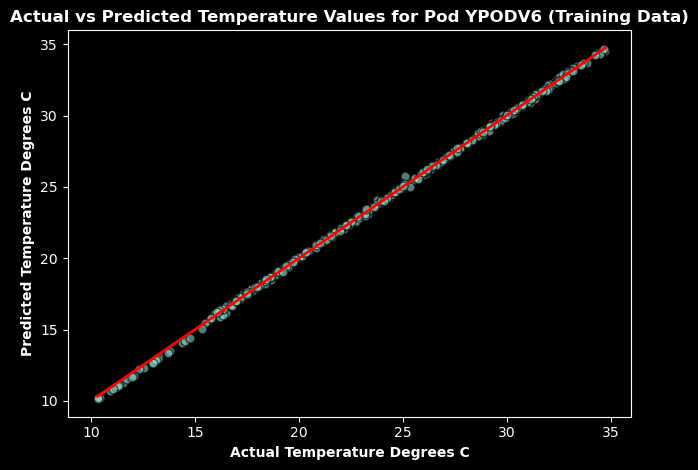

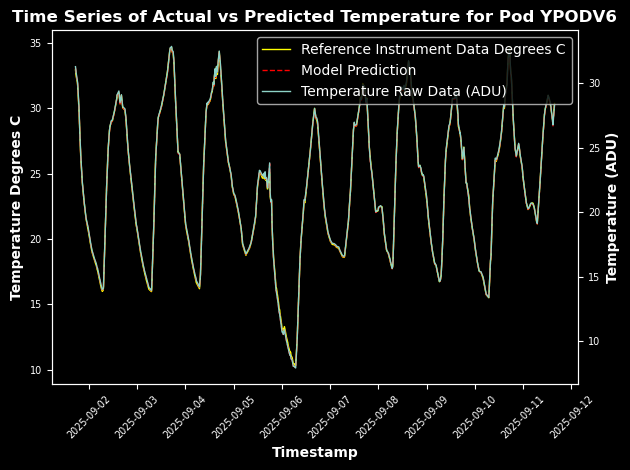

Pod YPODG2 Relative Humidity model:

Coefficients:
Relative Humidity: 0.76705

Intercept: 5.22100

R-squared: 0.98323
Mean absolute error: 0.8929830686616707
Mean squared error: 1.6771760092866543
Root mean squared error: 1.2950583034314147



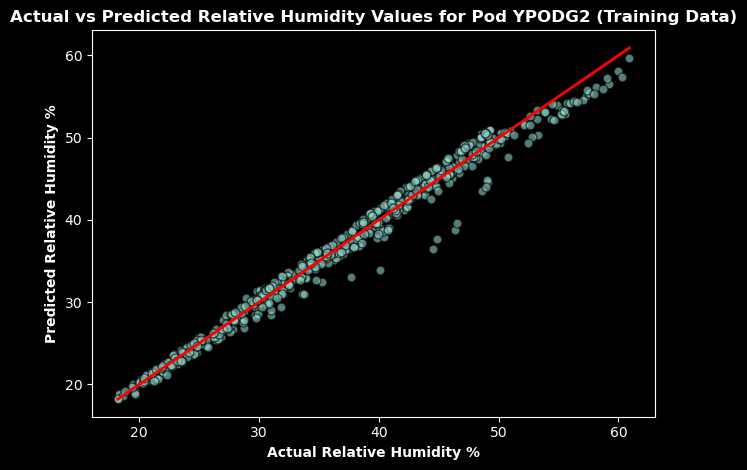

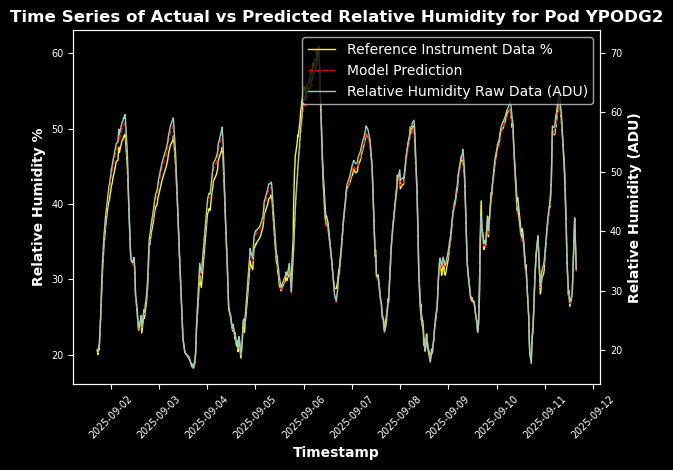

Pod YPODX1 has an incomplete Relative Humidity data set
Common timestamps: 2880
Reference data size: 2880

Pod YPODX1 Relative Humidity model:

Coefficients:
Relative Humidity: 0.96548

Intercept: 0.32820

R-squared: 0.99544
Mean absolute error: 0.5218588646112382
Mean squared error: 0.455666569887902
Root mean squared error: 0.6750307918072346



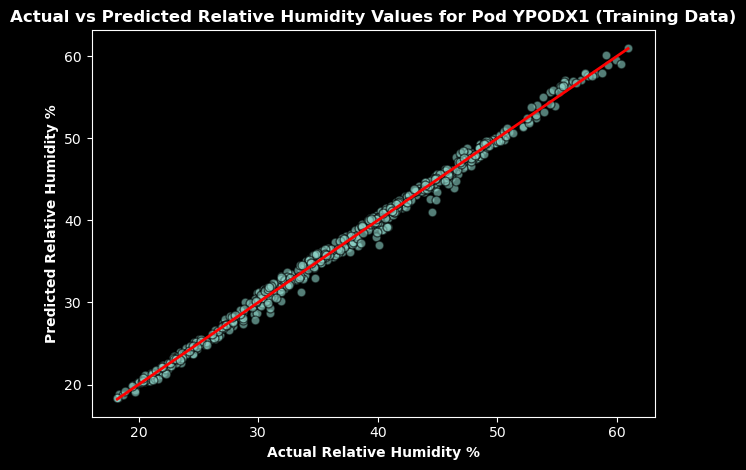

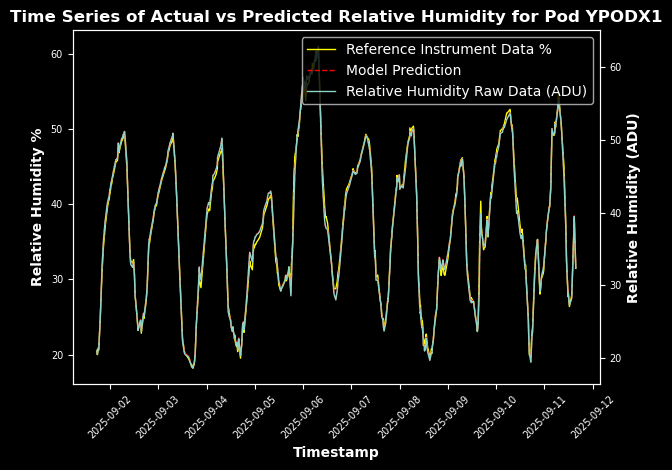

Pod YPODK2 has an incomplete Relative Humidity data set
Common timestamps: 2880
Reference data size: 2880

Pod YPODK2 Relative Humidity model:

Coefficients:
Relative Humidity: 0.96193

Intercept: -3.51642

R-squared: 0.97886
Mean absolute error: 1.0143695451808883
Mean squared error: 2.1134600547582036
Root mean squared error: 1.4537744167367246



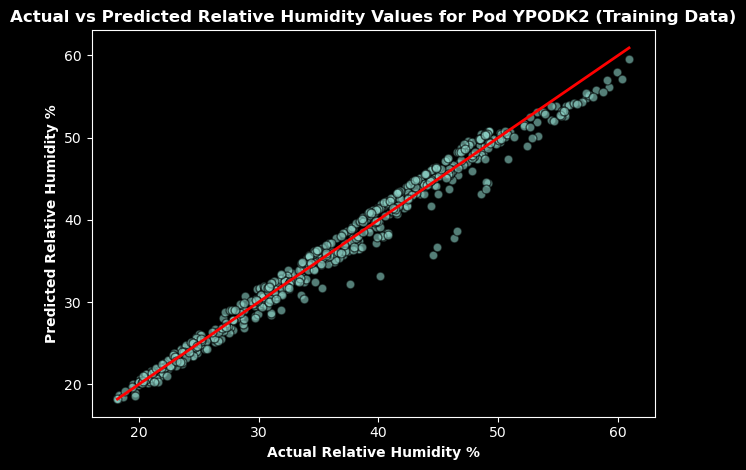

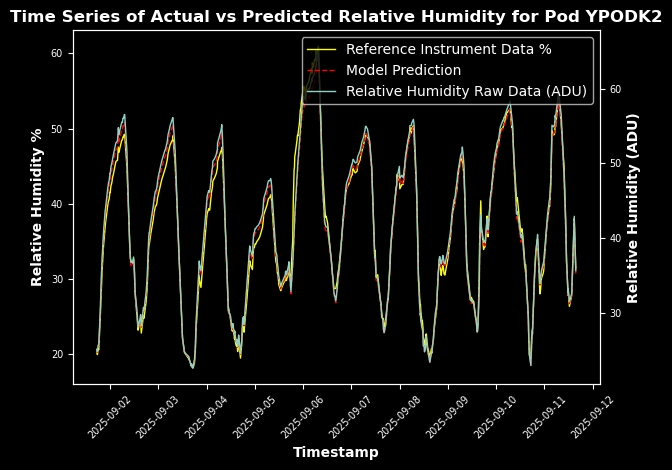

Pod YPODK4 has an incomplete Relative Humidity data set
Common timestamps: 24
Reference data size: 2880

Pod YPODK4 Relative Humidity model:

Coefficients:
Relative Humidity: 0.89132

Intercept: -4.24431

R-squared: 0.98638
Mean absolute error: 0.0704082589604134
Mean squared error: 0.006950477623794632
Root mean squared error: 0.08336952455060921



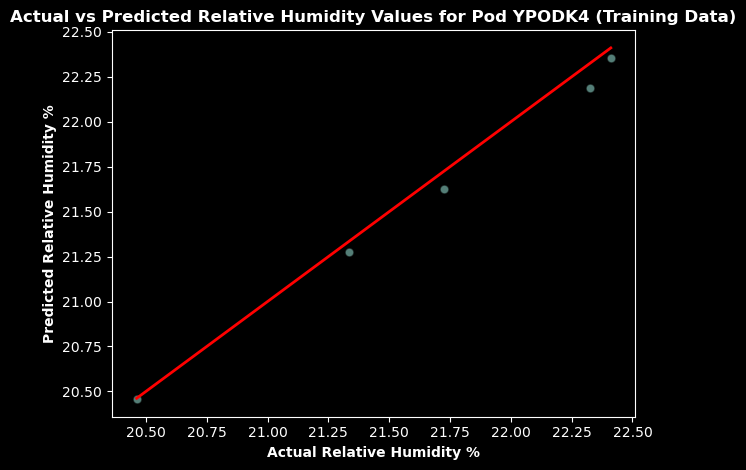

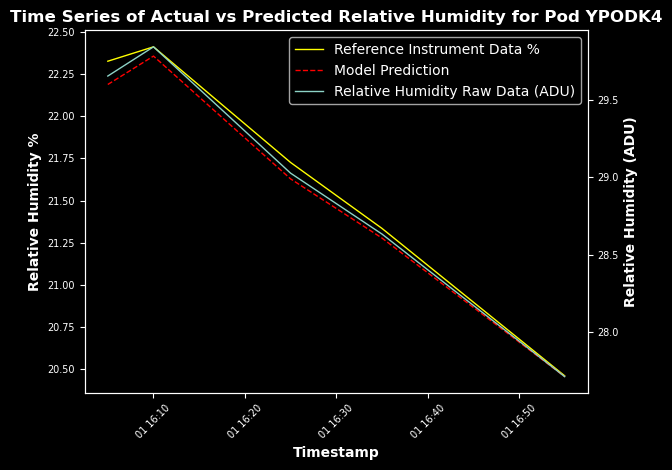

Pod YPODL1 Relative Humidity model:

Coefficients:
Relative Humidity: 0.87818

Intercept: 1.71694

R-squared: 0.99771
Mean absolute error: 0.3060554860635809
Mean squared error: 0.2289812255581157
Root mean squared error: 0.4785198277585953



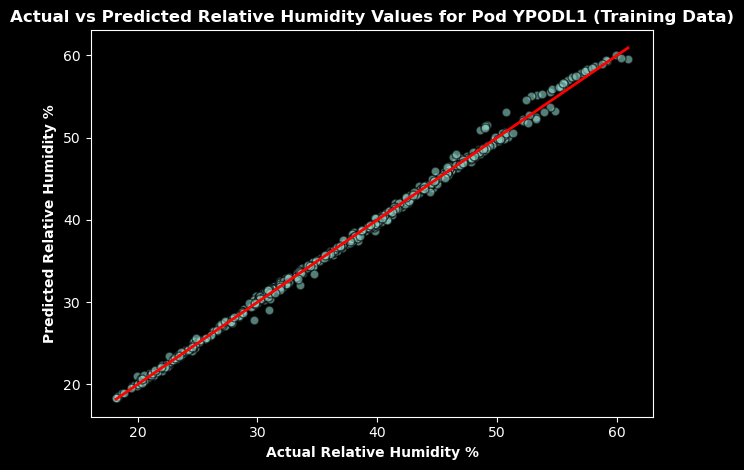

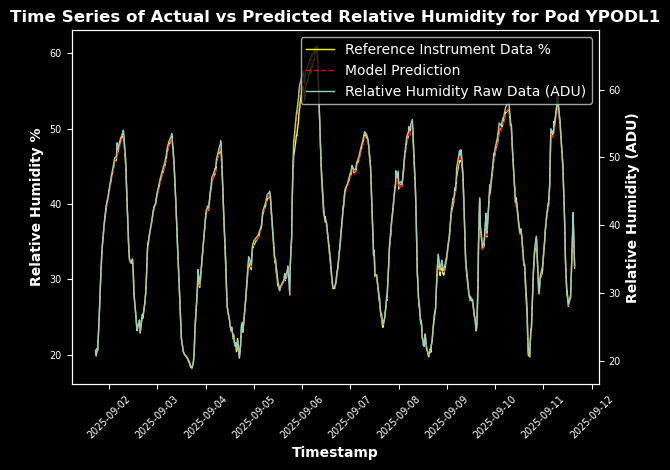

Pod YPODT1 Relative Humidity model:

Coefficients:
Relative Humidity: 0.99291

Intercept: -5.18356

R-squared: 0.99945
Mean absolute error: 0.1904072903037193
Mean squared error: 0.05536420152167984
Root mean squared error: 0.23529598704967292



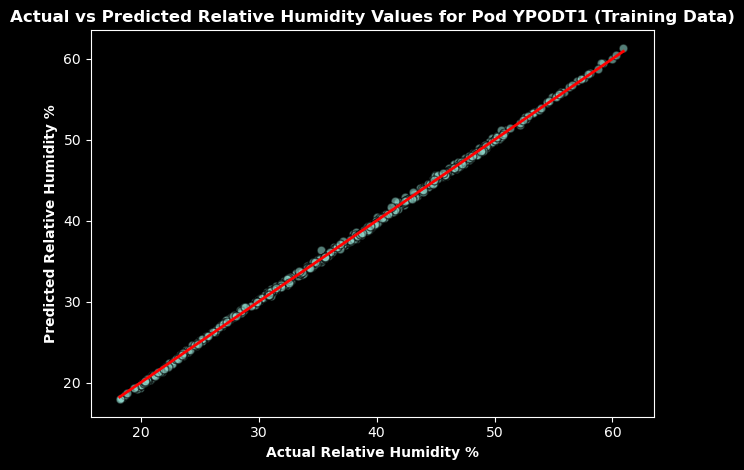

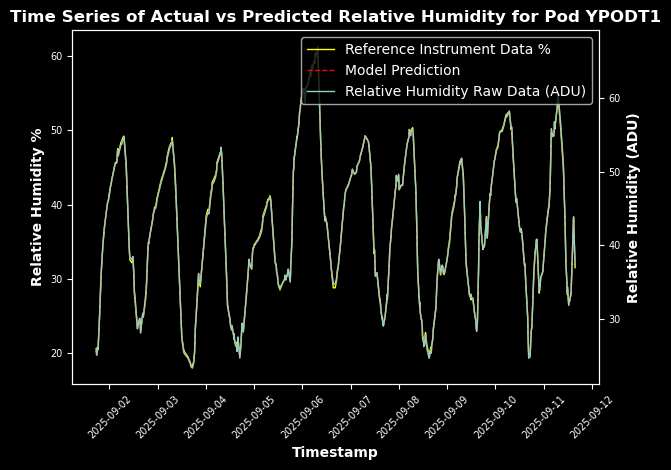

Pod YPODT4 has an incomplete Relative Humidity data set
Common timestamps: 2383
Reference data size: 2880

Pod YPODT4 Relative Humidity model:

Coefficients:
Relative Humidity: 0.78593

Intercept: 4.49997

R-squared: 0.99553
Mean absolute error: 0.5349340803910514
Mean squared error: 0.4839335971222317
Root mean squared error: 0.6956533598871149



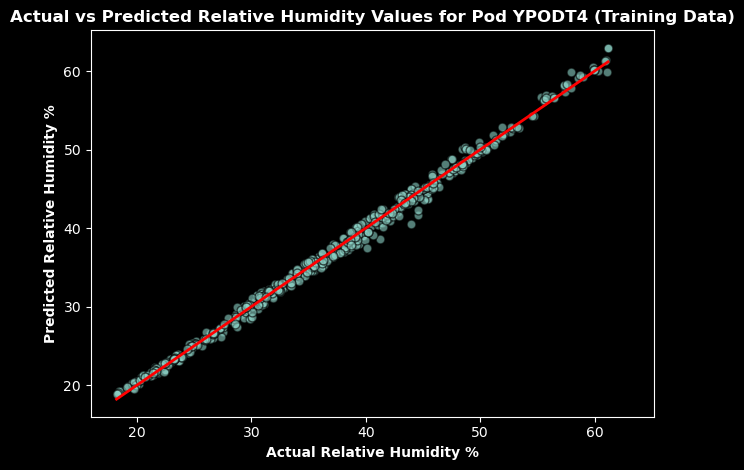

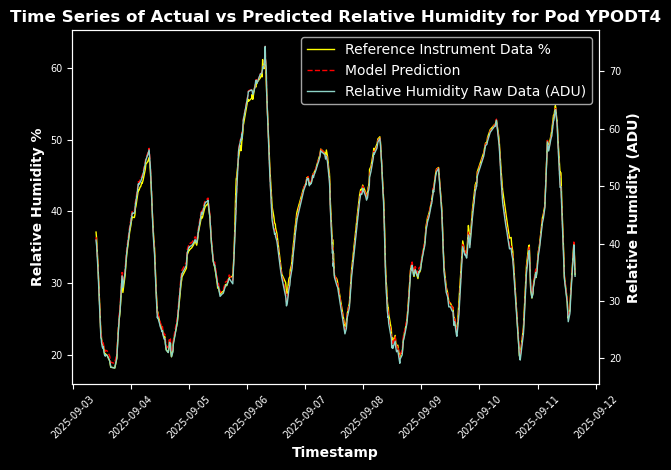

Pod YPODT6 Relative Humidity model:

Coefficients:
Relative Humidity: 0.92664

Intercept: -5.81132

R-squared: 0.99475
Mean absolute error: 0.5081705713575019
Mean squared error: 0.5250984651652312
Root mean squared error: 0.7246367815431612



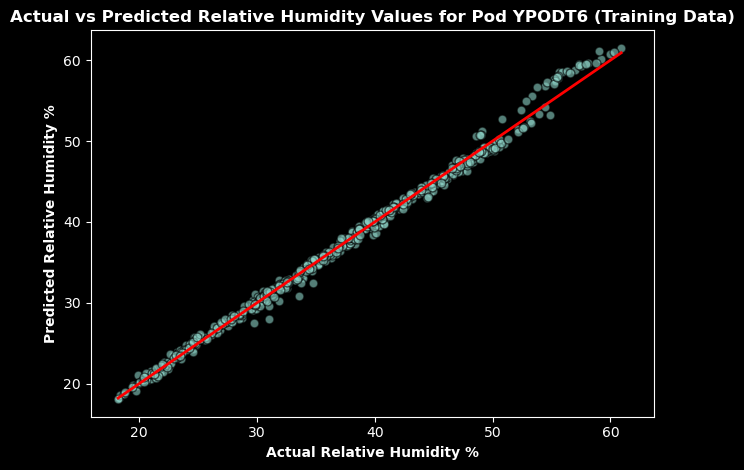

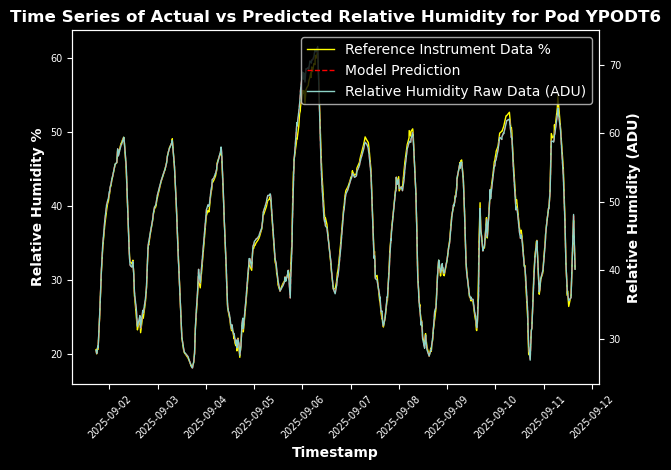

Pod YPODU1 Relative Humidity model:

Coefficients:
Relative Humidity: 0.76088

Intercept: 4.51091

R-squared: 0.99494
Mean absolute error: 0.44902958552799155
Mean squared error: 0.5061950076365842
Root mean squared error: 0.7114738277945185



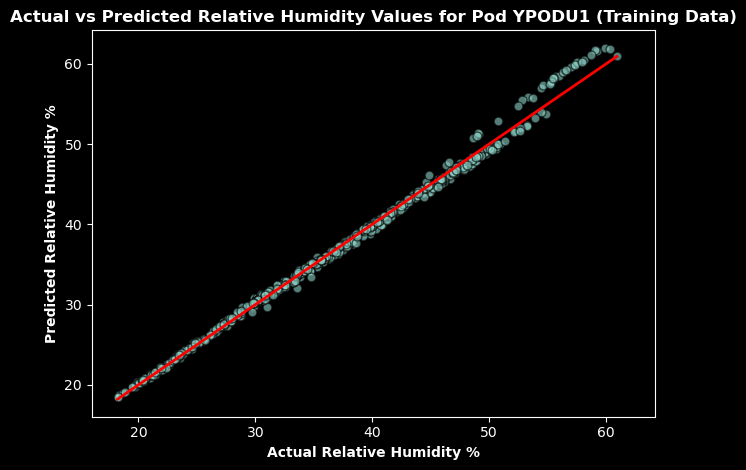

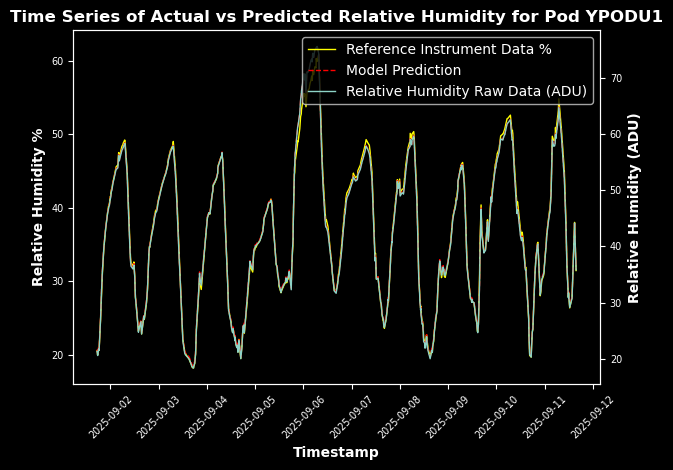

Pod YPODU3 Relative Humidity model:

Coefficients:
Relative Humidity: 0.86923

Intercept: -1.05297

R-squared: 0.99445
Mean absolute error: 0.46060546131401675
Mean squared error: 0.5547431575256331
Root mean squared error: 0.7448108199574125



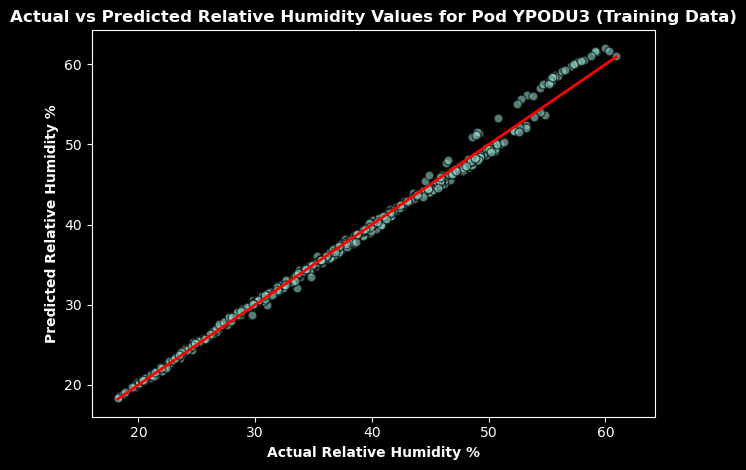

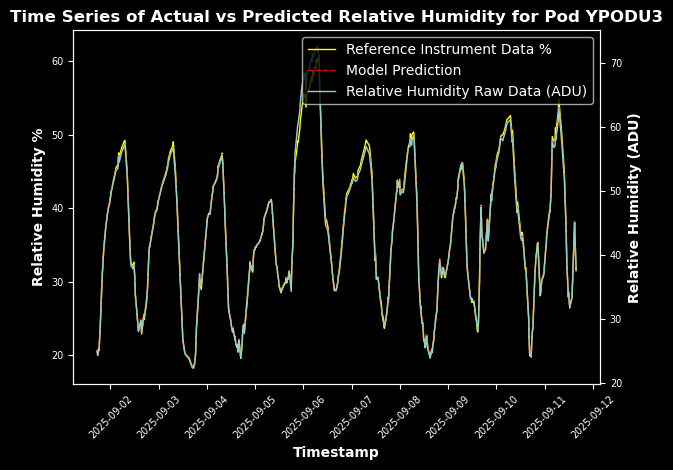

Pod YPODU5 Relative Humidity model:

Coefficients:
Relative Humidity: 0.84466

Intercept: 1.02186

R-squared: 0.98594
Mean absolute error: 0.861831276652575
Mean squared error: 1.4060965084084753
Root mean squared error: 1.185789403059614



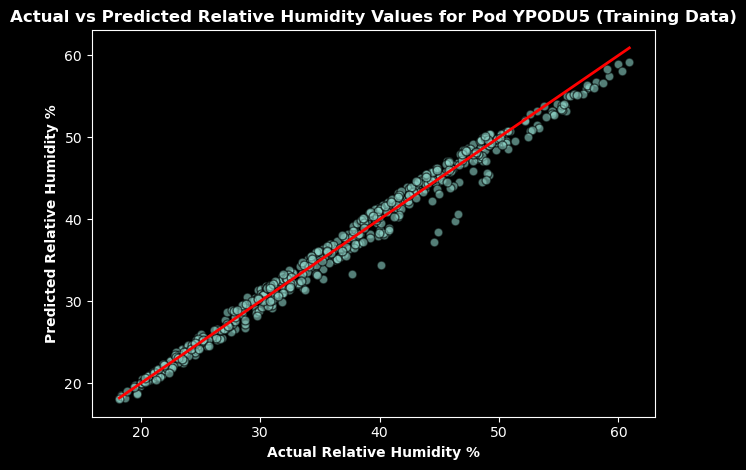

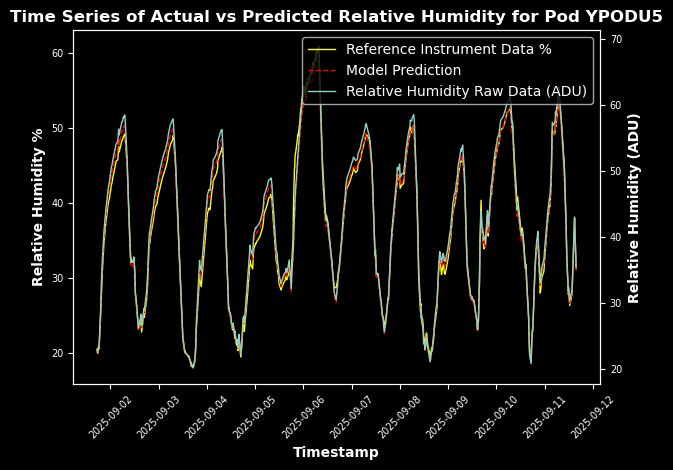

Pod YPODV2 Relative Humidity model:

Coefficients:
Relative Humidity: 0.84372

Intercept: 2.94169

R-squared: 0.98547
Mean absolute error: 0.8682405524327395
Mean squared error: 1.4526335593127895
Root mean squared error: 1.2052524877853559



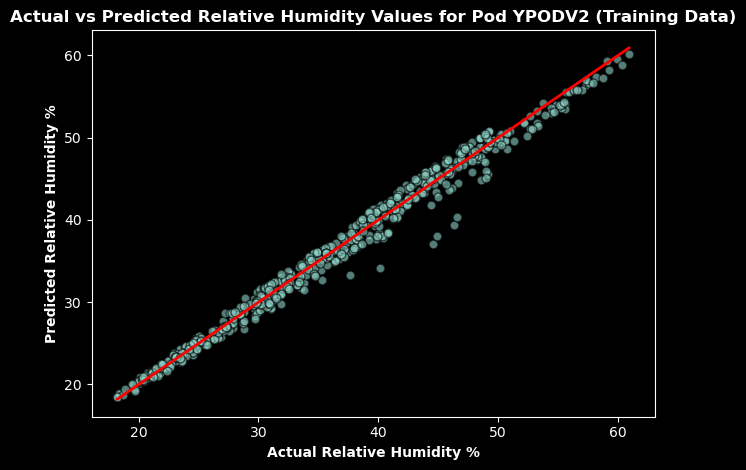

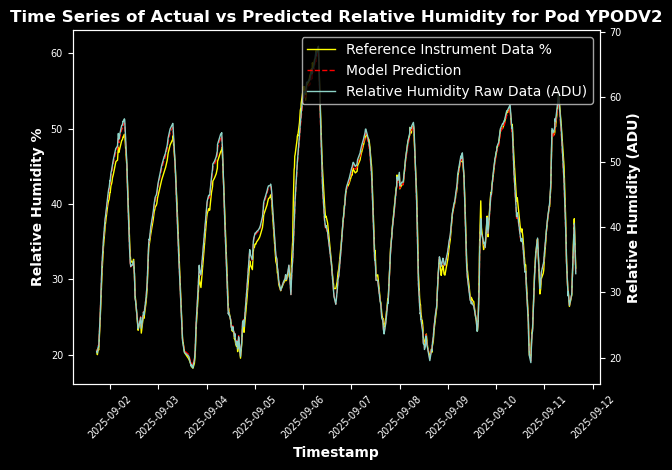

Pod YPODV6 Relative Humidity model:

Coefficients:
Relative Humidity: 0.85409

Intercept: 1.26824

R-squared: 0.99655
Mean absolute error: 0.38628807316710023
Mean squared error: 0.34527039804474097
Root mean squared error: 0.5875971392414543



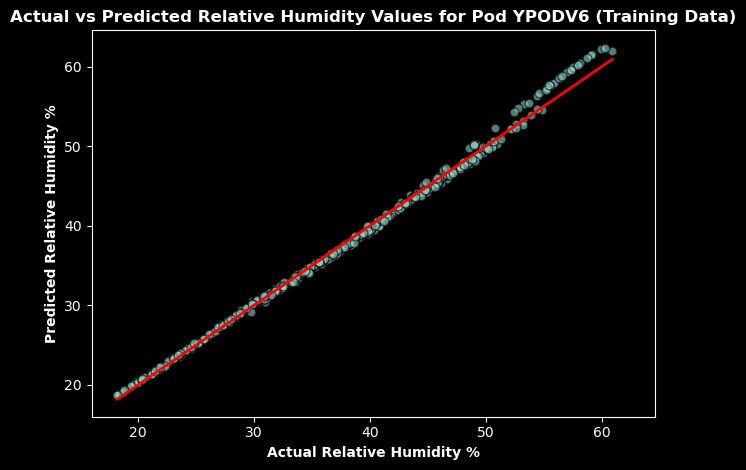

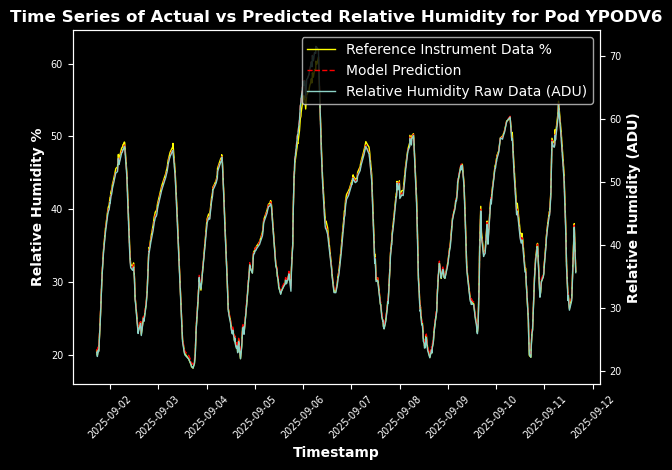

In [20]:
for model, ref_var, variables, units in zip(models, ref_cal_var, regr_var, calibrated_units) :

    ### for loop to run regression for each pod in dataset
    for pod in all_pod_data :

        pod_id_index = pod.iat[0, 7] # gets pod ID
        
        missing_vars = [v for v in variables if v not in pod.columns]
        if missing_vars:
            print(f"Missing variables in pod data: {missing_vars}")
            continue  # skip this pod if required variables are missing

        ### imputes all NaN values before running model
        pod_numeric = pod[variables].copy()  # only take the variables you care about

        if pod_numeric.empty:
            print(f"Pod {pod_id_index}: no numeric variables available, skipping...")
            continue
        imp = SimpleImputer(missing_values=np.nan, strategy="median")
        pod_imputed = pd.DataFrame(imp.fit_transform(pod_numeric),columns=pod_numeric.columns)
        
        ### assigning independent and dependent variables
        X = pod_imputed[variables] # pod variable(s) to fit
        y = reference_file[ref_var] # reference instrument data
    
        ### deals with pods that dont have the full data set
        if len(X) != len(y) : # if reference data size != pod data size
    
            ### adds timestamp back into dataframe for x and y 
            pod_imputed["Timestamp"] = pod["Timestamp"] # adds timestamp column back into pod_imputed dataframe
            pod_imputed.set_index("Timestamp") # sets timestamp as index
            pod_imputed = pod_imputed.reset_index() # resets index (housekeeping)
            reference_file.set_index("Timestamp") # sets timestamp as index
            # ref1_data = ref1_data.reset_index()
            X = pod_imputed[["Timestamp"] + variables] # redefines x to include timestamp
            y = reference_file[["Timestamp", ref_var]] # refefines y to include timestamp
            
            ### printing statements for ui
            common_times = X.index.intersection(y.index) # prints the number of matching indexes (timestamps)
            print(f"Pod {pod_id_index} has an incomplete {model} data set")
            print(f"Common timestamps: {len(common_times)}")
            print(f"Reference data size: {len(y)}\n")
    
            ### makes a temporary concatenated dataframe and deletes all data where timestamps do not match
            concat = pd.merge(X, y, on = "Timestamp").dropna()
            X = concat[variables]
            y = concat[[ref_var]] # shortens data set to timestamps that match y values
    
        ### running lienar regression model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10) # splits data into train and test
    
        ### creates linear regression model
        if linear_regression_mvlr == True : # regular linear regression
            regr = LinearRegression() 
        elif ridge_mvlr == True : # ridge linear model
            regr = Ridge(alpha = 1, random_state = 10)
        elif lasso_mvlr == True : # lasso linear model
            regr = Lasso(alpha = 1, random_state = 10)
        elif random_forest_model == True : # random forest ML
            regr = RandomForestRegressor(n_estimators = 100, random_state = 10)
        elif gradient_boost_model == True : # gradient boosting ML
            regr = XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, random_state = 10)
        else : # for user interface
            print("No regression model chosen, please set a model = True in the 'variables to change' section.")
        
        regr.fit(X_train, y_train) # runs linear regression model
    
        ### generates predicted values for testing set
        y_predicted = regr.predict(X_test)
        y_predicted = np.clip(y_predicted, a_min = 0, a_max = None) # prevents negative prediction values
        r2 = r2_score(y_test, y_predicted) # computes rsquared values for prediction
    
        ### print statements for model
        print(f"Pod {pod_id_index} {model} model:")
        
        ### if statement to print coefficients for different models
        if hasattr(regr, "coef_") : # prints coefficents and intercept for linear models
            print("\nCoefficients:")
            for pred, coef in zip(variables, regr.coef_.flatten()): # for loop to print coeficients for each variable in model
                print(f"{pred}: {coef:.5f}")
            print(f"\nIntercept: {regr.intercept_.item():.5f}") # prints the intercept for the model
        elif hasattr(regr, "feature_importances_") : # prints feature importantce for ML models
            print("\nFeature Importances:")
            for pred, importance in zip(variables, regr.feature_importances_):
                print(f"{pred}: {importance:.5f}")
        else :  # for user interface
            print("\nModel does not provide linear coefficients (e.g., Random Forest).")

        ### print statements for error types, model accuracy
        print(f"\nR-squared: {r2:.5f}") # prints r2 for model
        print(f"Mean absolute error: {metrics.mean_absolute_error(y_test, y_predicted)}")
        print(f"Mean squared error: {metrics.mean_squared_error(y_test, y_predicted)}")
        print(f"Root mean squared error: {np.sqrt(metrics.mean_squared_error(y_test, y_predicted))}\n")
    
        ### makes sure testing y values are numeric for plotting
        if isinstance(y_test, pd.DataFrame): # checks if the y_testing data is a dataframe type
            y_test = y_test.iloc[:, 0] # selects the 0th column of testing data (whole data set)
            y_test = pd.to_numeric(y_test, errors = "coerce") # converts all values to numeric

        ### model accuracy plotting
        if model_accuracy_plotting == True :
            plt.scatter(y_test, y_predicted, alpha = 0.6, s = 40, edgecolors = "black", linewidth = 1) # scatter plot for model accuracy
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = "red", linewidth = 2) # y = x line
            min_val = min(y_test.min(), y_predicted.min()) # calculates the min of data set
            max_val = max(y_test.max(), y_predicted.max()) # calculates the max of data set
            pad = (max_val - min_val) * 0.05 # adds padding to the ends of the axes
            plt.xlim(min_val - pad, max_val + pad) # sets x limit
            plt.ylim(min_val - pad, max_val + pad) # sets y limit
            # plt.gca().set_aspect("equal", adjustable = "box") # makes the plot a square
            plt.xlabel(f"Actual {model} {units}", fontweight = "bold") # x axis label
            plt.ylabel(f"Predicted {model} {units}", fontweight = "bold") # y axis label
            plt.title(f"Actual vs Predicted {model} Values for Pod {pod_id_index} (Training Data)", fontweight = "bold") # plot title
            plt.tight_layout()
            
            ### saving charts to directory for easy access
            if save_plots == True :
                name = f"{pod_id_index}_{model.replace(" ", "_")}_model_accuracy.png" # names file
                path = os.path.join(save_dir, name) # uses path.join for compatibility across os, (good to prevent bugs)
                plt.savefig(path, dpi = 300) # saves figure to specified path directory
                print(f"Saved: {path}") # for ui, prints confirmation of saved file
                
            plt.show() # displays plot

        ### time series plotting
        if model_timeseries_plotting == True:
            fig, ax1 = plt.subplots() # sub axes for dual axis plot
            X_test["Timestamp"] = pod["Timestamp"].iloc[X_test.index] # aligns with original timestamps
            X_test["Model Prediction"] = y_predicted.flatten() # reshapes data into an array, adds to "predicted" in dataframe
            X_test["Reference Instrument Data"] = y_test.values.flatten() # reshapes data into an array, adds to "acrual" in dataframe, takes values
            X_test = X_test.sort_values("Timestamp") # sort by timestamp, not guaranteed after train_test_split
            ax1.plot(X_test["Timestamp"], X_test["Reference Instrument Data"], 
                     label = f"Reference Instrument Data {units}", color = "yellow", linewidth = 1) # plot for actual data
            ax1.plot(X_test["Timestamp"], X_test["Model Prediction"], label = "Model Prediction",
                     color = "red", linestyle = "--", linewidth = 1) # plot for predicted data
            ax1.set_xlabel("Timestamp", fontweight = "bold", ) # x axis label
            ax1.set_ylabel(f"{model} {units}", fontweight = "bold") # y axis label
            ax1.tick_params(axis = "x", labelsize = 7, labelrotation = 45) # changes fontsize of x axis
            ax1.tick_params(axis = "y", labelsize = 7) # changes fontsize of y axis
            h1, l1 = ax1.get_legend_handles_labels() # stores first ax legend labels and handles
            if display_pod_data_timeseries == True : # if statement to display pod data on graph
                ax2 = ax1.twinx() # creates another axis for dual axis plot
                raw_series = pod[["Timestamp", model]].dropna()
                merged = pd.merge(X_test[["Timestamp"]], raw_series, on = "Timestamp", how = "left")
                ax2.plot(merged["Timestamp"], merged[model], label = f"{model} Raw Data (ADU)", linewidth = 1) # plot for raw data
                ax2.set_ylabel(f"{model} (ADU)", fontweight = "bold")
                ax2.tick_params(axis = "y", labelsize = 7) # changes fontsize of y axis
                h2, l2 = ax2.get_legend_handles_labels() # stores second ax legend labels and handles
                handles = h1 + h2 # creates a handles type
                labels = l1 + l2 # creates a labels type
            else :
                handles = h1 # creates a handles type
                labels = l1 # creates a labels type
            plt.legend(handles, labels, loc = 'upper right') # creates a combined legend
            
            plt.title(f"Time Series of Actual vs Predicted {model} for Pod {pod_id_index}", fontweight = "bold") # plot title
            plt.tight_layout()
            
            ### saving charts to directory for easy access
            if save_plots == True :
                name = f"{pod_id_index}_{model.replace(" ", "_")}_model_timeseries.png" # names file
                path = os.path.join(save_dir, name) # uses path.join for compatibility across os, (good to prevent bugs)
                plt.savefig(path, dpi = 300) # saves figure to specified path directory
                print(f"Saved: {path}") # for ui, prints confirmation of saved file

            plt.show() # displays plot